In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis
)
from ripple_heterogeneity.readout import assembly_multi_region_pos_maps_tmaze,assembly_multi_region_pos_maps_tmaze_ind_detect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
import nelpy as nel
from statannotations.Annotator import Annotator
import glob
import pickle
from scipy.stats import zscore
from statsmodels.stats.proportion import proportions_ztest
from sklearn.linear_model import LinearRegression
import random
import pycircstat as circstat

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## locate sessions

In [2]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

epoch_df = pd.DataFrame()
for basepath in df.basepath.unique():

    epoch_df_ = loading.load_epoch(basepath)
    df_temp_regions = pd.DataFrame()
    df_temp_regions["regions"] = loading.load_brain_regions(basepath).keys()
    epoch_df_["mec"] = df_temp_regions.regions.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").any()
    epoch_df_["pfc"] = df_temp_regions.regions.str.contains("PFC").any()

    epoch_df_["basepath"] = basepath

    epoch_df = pd.concat([epoch_df,epoch_df_],ignore_index=True)

In [ ]:
epoch_df.query("environment.str.contains('wmaze') & (mec|pfc)").basepath.unique()

In [3]:
session_df = pd.DataFrame()
session_df["basepath"] = epoch_df.query("environment.str.contains('Mwheel|Tmaze|tmaze') & (mec|pfc)").basepath.unique()
# session_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\tmaze_sessions.csv",index=False)

## main analysis

In [187]:
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v2")
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v3")
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v4")
# has restriction to theta
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v5") 

# same as v4, but with circular smoothing
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v6")

# same as v6, but with 100ms bins for weight_dt
save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v7") # best so far

# same as v7, but with 120ms bins for weight_dt
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v8")

# same as v8, but with 125ms bins for weight_dt
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v9")

# same as v9, but with 35ms bins for weight_dt
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v10")

# same as v10, but with 50ms bins for weight_dt
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v11")

# same as v11, but with 50ms bins for weight_dt and confirm cross region assembly False
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v12")

# same as v12, but with 100ms bins for weight_dt and some sessions have updated cellexplorer files
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v13")

# same as v13, but with 50ms bins for weight_dt
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v14")

# same as v7 but with updated sessions (weight_dt=0.1, confirm_cross_region=True)
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v15")

# same as v15 but with updated sessions (weight_dt=0.1, confirm_cross_region=False)
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v16")

batch_analysis.run(
    session_df,
    save_path,
    assembly_multi_region_pos_maps_tmaze_ind_detect.run,
    parallel=True,
    overwrite=False,
    verbose=False,
    skip_if_error=False,
    weight_dt=0.1,
    confirm_cross_region=True
)
# load results
tc, label_df = assembly_multi_region_pos_maps_tmaze_ind_detect.load_results(save_path)

100%|██████████| 53/53 [00:06<00:00,  8.71it/s] 


Loading results...


## simplify labels

In [188]:
label_df.loc[label_df.cross_region_label=="Deep_EC1|EC2|EC3|EC4|EC5|MEC","cross_region_label"] = "deep_mec"
label_df.loc[label_df.cross_region_label=="Superficial_EC1|EC2|EC3|EC4|EC5|MEC","cross_region_label"] = "sup_mec"
label_df.loc[label_df.cross_region_label=="Deep_PFC","cross_region_label"] = "deep_pfc"
label_df.loc[label_df.cross_region_label=="Superficial_PFC","cross_region_label"] = "sup_pfc"
label_df

,assembly_n,direction_label,cross_region_label,x_start,x_decision,x_reward_left,x_reward_right,basepath
0,0,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
1,1,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
2,2,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
3,3,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
4,4,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
...,...,...,...,...,...,...,...,...
355,1,left_epochs,deep_mec,0.0,87.984048,257.212112,257.810041,Z:\Data\Kenji\ec014.427_456
356,0,right_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487
357,1,right_epochs,sup_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487
358,0,left_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487


In [189]:
label_df.cross_region_label.unique()

array(['deep_mec', 'sup_mec', 'deep_pfc', 'sup_pfc'], dtype=object)

In [190]:
ratemaps = []
for tc_ in tc:
    for ratemap in tc_.values.T:
        ratemaps.append(np.interp(np.linspace(0,len(ratemap),100),np.arange(len(ratemap)),ratemap))
ratemaps = np.vstack(ratemaps)
ratemaps[np.isnan(ratemaps)] = 0
ratemaps = zscore(ratemaps,axis=1)

## get ratemaps beyond the decision point

In [8]:
ratemaps = []
for basepath_i, basepath in enumerate(label_df.basepath.unique()):

    label_df_current = label_df.query("basepath==@basepath")
    right_epochs_maps = tc[basepath_i].iloc[tc[basepath_i].index > label_df.x_decision[basepath_i]+6,(label_df_current.direction_label=="right_epochs").values]
    left_epochs_maps = tc[basepath_i].iloc[tc[basepath_i].index > label_df.x_decision[basepath_i]+6,(label_df_current.direction_label=="left_epochs").values]


    for i in range(tc[basepath_i].shape[1]):
        ratemap = tc[basepath_i].iloc[tc[basepath_i].index > label_df.x_decision[basepath_i],i]
        ratemaps.append(np.interp(np.linspace(0,len(ratemap),100),np.arange(len(ratemap)),ratemap))

ratemaps = np.vstack(ratemaps)
ratemaps[np.isnan(ratemaps)] = 0
ratemaps = zscore(ratemaps,axis=1)

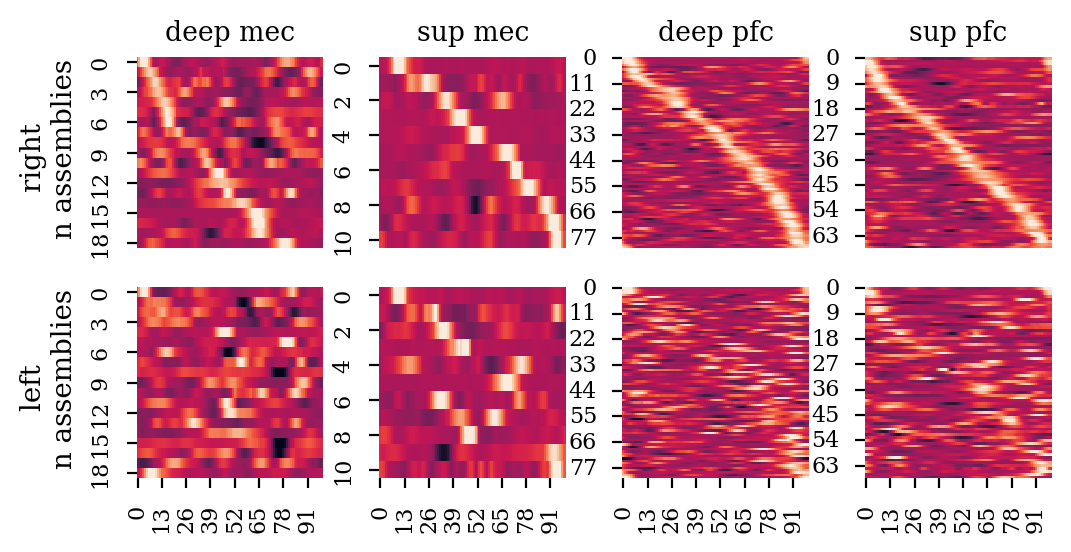

In [191]:
def make_snake(X):
    return np.argsort(np.argmax(X,axis=1))
fig, ax = plt.subplots(2,4, figsize=functions.set_size('thesis', fraction=1, subplots=(3, 4)), edgecolor=None)
fig.subplots_adjust(hspace = 0.2, wspace=.3)
ax = ax.ravel()

curr_maps = ratemaps[(label_df.cross_region_label == "deep_mec") & (label_df.direction_label == "right_epochs"),:]
idx = make_snake(curr_maps)
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[0],cbar=False,rasterized=True)
curr_maps = ratemaps[(label_df.cross_region_label == "deep_mec") & (label_df.direction_label == "left_epochs"),:]
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[4],cbar=False,rasterized=True)

curr_maps = ratemaps[(label_df.cross_region_label == "sup_mec") & (label_df.direction_label == "right_epochs"),:]
idx = make_snake(curr_maps)
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[1],cbar=False,rasterized=True)
curr_maps = ratemaps[(label_df.cross_region_label == "sup_mec") & (label_df.direction_label == "left_epochs"),:]
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[5],cbar=False,rasterized=True)

curr_maps = ratemaps[(label_df.cross_region_label == "deep_pfc") & (label_df.direction_label == "right_epochs"),:]
idx = make_snake(curr_maps)
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[2],cbar=False,rasterized=True)
curr_maps = ratemaps[(label_df.cross_region_label == "deep_pfc") & (label_df.direction_label == "left_epochs"),:]
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[6],cbar=False,rasterized=True)

curr_maps = ratemaps[(label_df.cross_region_label == "sup_pfc") & (label_df.direction_label == "right_epochs"),:]
idx = make_snake(curr_maps)
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[3],cbar=False,rasterized=True)
curr_maps = ratemaps[(label_df.cross_region_label == "sup_pfc") & (label_df.direction_label == "left_epochs"),:]
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[7],cbar=False,rasterized=True)

ax[0].set_title("deep mec")
ax[1].set_title("sup mec")
ax[2].set_title("deep pfc")
ax[3].set_title("sup pfc")

ax[0].set_ylabel("right \n n assemblies")
ax[4].set_ylabel("left \n n assemblies")

for i in [0,1,2,3]:
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_xlabel("")

## analyses

* direction correlation 
* reward encoding (%20 around loc)
* assembly rate map examples
* decision point encoding (%20 around loc)

## spatial correlations across right and left directions

In [192]:
corrs = []
labels = []

outbound_deep_mec = ratemaps[(label_df.cross_region_label == "deep_mec") & (label_df.direction_label == "right_epochs"),:]
inbound_deep_mec = ratemaps[(label_df.cross_region_label == "deep_mec") & (label_df.direction_label == "left_epochs"),:]

for i in range(outbound_deep_mec.shape[0]):
    corrs.append(np.corrcoef(outbound_deep_mec[i],inbound_deep_mec[i])[0,1])
    labels.append("deep_mec")

outbound = ratemaps[(label_df.cross_region_label == "sup_mec") & (label_df.direction_label == "right_epochs"),:]
inbound = ratemaps[(label_df.cross_region_label == "sup_mec") & (label_df.direction_label == "left_epochs"),:]
for i in range(outbound.shape[0]):
    corrs.append(np.corrcoef(outbound[i],inbound[i])[0,1])
    labels.append("sup_mec")
    
outbound = ratemaps[(label_df.cross_region_label == "deep_pfc") & (label_df.direction_label == "right_epochs"),:]
inbound = ratemaps[(label_df.cross_region_label == "deep_pfc")  & (label_df.direction_label == "left_epochs"),:]
for i in range(outbound.shape[0]):
    corrs.append(np.corrcoef(outbound[i],inbound[i])[0,1])
    labels.append("deep_pfc")

outbound = ratemaps[(label_df.cross_region_label == "sup_pfc") & (label_df.direction_label == "right_epochs"),:]
inbound = ratemaps[(label_df.cross_region_label == "sup_pfc") & (label_df.direction_label == "left_epochs"),:]
for i in range(outbound.shape[0]):
    corrs.append(np.corrcoef(outbound[i],inbound[i])[0,1])
    labels.append("sup_pfc")

df_corrs = pd.DataFrame()
df_corrs["corrs"] = corrs
df_corrs["labels"] = labels
df_corrs["constant"] = 1

Text(0.5, 0, '')

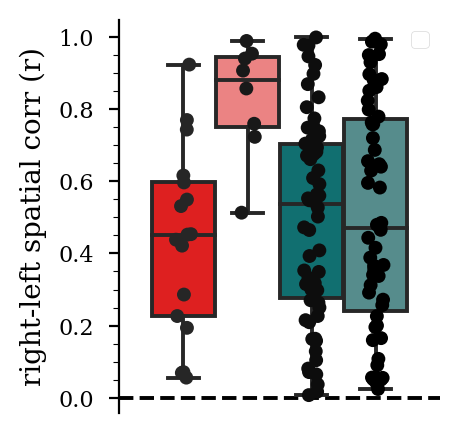

In [193]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
sns.boxplot(data=df_corrs.query("corrs>0"),x="constant",y="corrs",hue="labels",hue_order=group_colors.keys(),showfliers=False,saturation=1)
sns.stripplot(data=df_corrs.query("corrs>0"),x="constant",y="corrs",hue="labels",hue_order=group_colors.keys(),dodge=True,color="k")

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("right-left spatial corr (r)")
plt.axhline(0,color="k",linestyle="--",zorder=-1000)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

In [347]:
df_corrs.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_df_corrs.csv")

## reward representation

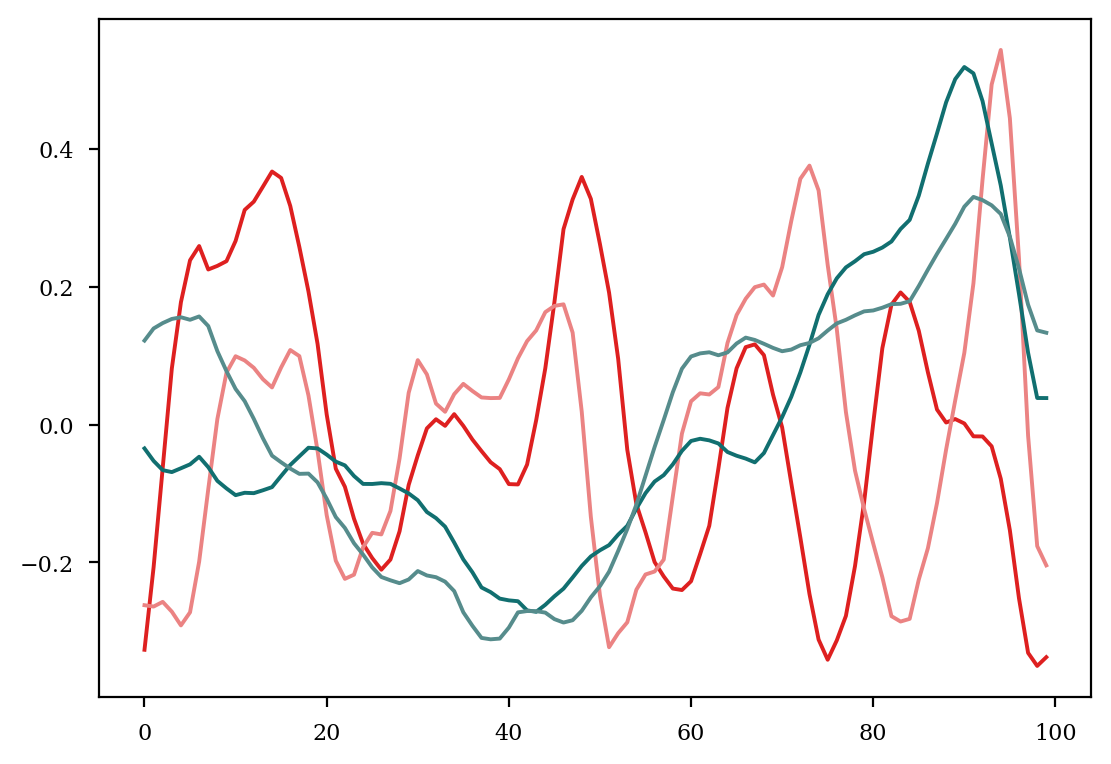

In [194]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

curr_maps = ratemaps[(label_df.cross_region_label == "deep_mec"),:]
plt.plot(curr_maps.mean(axis=0),label="deep_mec",color=group_colors["deep_mec"])

curr_maps = ratemaps[(label_df.cross_region_label == "sup_mec"),:]
plt.plot(curr_maps.mean(axis=0),label="sup_mec",color=group_colors["sup_mec"])

curr_maps = ratemaps[(label_df.cross_region_label == "deep_pfc"),:]
plt.plot(curr_maps.mean(axis=0),label="deep_pfc",color=group_colors["deep_pfc"])

curr_maps = ratemaps[(label_df.cross_region_label == "sup_pfc"),:]
plt.plot(curr_maps.mean(axis=0),label="sup_pfc",color=group_colors["sup_pfc"])
plt.show()

In [195]:
label_df = functions.add_animal_id(label_df)
len(tc),label_df.basepath.nunique(),label_df.animal_id.nunique()

(24, 24, 8)

## run regression between distance to reward and assembly strength

Also, to circular v test for the assembly rate maps to see if they have a preferred direction to the reward

takes around 5-6 minutes to run

In [196]:
def score_xy(x, y, n_shuffles=400):
    reg = LinearRegression().fit(x, y)
    r2_obs = reg.score(x, y)
    slope = reg.coef_
    # shuffle x and fit
    r2_shuff = []
    for _ in range(n_shuffles):
        x_new = np.array(
            random.sample(list(x.flatten()), k=int(len(x.flatten())))
        ).reshape((-1, 1))
        reg = LinearRegression().fit(x_new, y)
        r2_shuff.append(reg.score(x_new, y))

    # significance test
    _, pval, std = functions.get_significant_events(r2_obs, np.array(r2_shuff))

    return r2_obs, r2_shuff, pval, std, slope

def circt_score_w_vtest(key_loc, current_tc):
    theta_loc = np.interp(
        key_loc,
        current_tc.index,
        np.arange(0, 2 * np.pi, 2 * np.pi / len(current_tc.index)),
    )
    theta = np.interp(
        current_tc.index,
        current_tc.index,
        np.arange(0, 2 * np.pi, 2 * np.pi / len(current_tc.index)),
    )

    pval_vtest, v_vtest = circstat.vtest(
        theta,
        mu=theta_loc,
        w=current_tc[col_i].values,
        d=np.unique((np.diff(theta)))[0],
    )
    return pval_vtest, v_vtest

r2_obs = np.zeros_like(label_df.basepath.values) * np.nan
pval = np.zeros_like(r2_obs) * np.nan
std = np.zeros_like(r2_obs) * np.nan
slope = np.zeros_like(r2_obs) * np.nan
pval_vtest_reward = np.zeros_like(r2_obs) * np.nan
v_vtest_reward = np.zeros_like(r2_obs) * np.nan
pval_vtest_decision = np.zeros_like(r2_obs) * np.nan
v_vtest_decision = np.zeros_like(r2_obs) * np.nan
r2_obs_decision = np.zeros_like(r2_obs) * np.nan
pval_decision = np.zeros_like(r2_obs) * np.nan
std_decision = np.zeros_like(r2_obs) * np.nan
slope_decision = np.zeros_like(r2_obs) * np.nan

i = 0
for basepath_i, basepath in enumerate(label_df.basepath.unique()):

    label_df_current = label_df.query("basepath==@basepath")
    current_tc = tc[basepath_i]

    for col_i in current_tc.columns:

        if label_df_current.iloc[col_i].direction_label == "right_epochs":
            reward_x = label_df_current.iloc[col_i].x_reward_right

        elif label_df_current.iloc[col_i].direction_label == "left_epochs":
            reward_x = label_df_current.iloc[col_i].x_reward_left

        x_decision = label_df_current.iloc[col_i].x_decision

        # do regression between distance to reward and assembly strength
        x = np.array(np.abs(current_tc.index - reward_x)).reshape((-1, 1))
        y = current_tc[col_i].values
        r2_obs[i], _, pval[i], std[i], slope[i] = score_xy(x, y)

        # same with decision point
        x = np.array(np.abs(current_tc.index - x_decision)).reshape((-1, 1))
        y = current_tc[col_i].values
        r2_obs_decision[i], _, pval_decision[i], std_decision[i], slope_decision[i] = score_xy(x, y)

        # calculate circular v test to see if assembly is centered on reward (tmaze is circular)
        # get reward location in polar coordinates
        pval_vtest_reward[i], v_vtest_reward[i] = circt_score_w_vtest(reward_x, current_tc)
        pval_vtest_decision[i], v_vtest_decision[i] = circt_score_w_vtest(x_decision, current_tc)

        i += 1


c:\Users\Cornell\anaconda3\envs\ripple_heterogeneity\lib\site-packages\pycircstat\tests.py:302: RuntimeWarning: invalid value encountered in sqrt
c:\Users\Cornell\anaconda3\envs\ripple_heterogeneity\lib\site-packages\pycircstat\tests.py:302: RuntimeWarning: invalid value encountered in sqrt
c:\Users\Cornell\anaconda3\envs\ripple_heterogeneity\lib\site-packages\pycircstat\tests.py:302: RuntimeWarning: invalid value encountered in sqrt
c:\Users\Cornell\anaconda3\envs\ripple_heterogeneity\lib\site-packages\pycircstat\tests.py:302: RuntimeWarning: invalid value encountered in sqrt
c:\Users\Cornell\anaconda3\envs\ripple_heterogeneity\lib\site-packages\pycircstat\tests.py:302: RuntimeWarning: invalid value encountered in sqrt
c:\Users\Cornell\anaconda3\envs\ripple_heterogeneity\lib\site-packages\pycircstat\tests.py:302: RuntimeWarning: invalid value encountered in sqrt
c:\Users\Cornell\anaconda3\envs\ripple_heterogeneity\lib\site-packages\pycircstat\tests.py:302: RuntimeWarning: invalid valu

In [197]:
# store linear regression reward results in dataframe
label_df["reward_r2"] = np.hstack(r2_obs)
label_df["reward_pval"] = np.hstack(pval)
label_df["reward_shuffle_std"] = np.hstack(std)
label_df["reward_relation_slope"] = np.hstack(slope)
label_df["reward_encode"] = (label_df.reward_pval<0.05) & (label_df.reward_relation_slope < 0)

# store circular v test reward results in dataframe
label_df["pval_vtest_reward"] = np.hstack(pval_vtest_reward)
label_df["v_vtest_reward"] = np.hstack(v_vtest_reward)
label_df["reward_encode_vtest"] = label_df.pval_vtest_reward<0.05

# store linear regression decision results in dataframe
label_df["pval_vtest_decision"] = np.hstack(pval_vtest_decision)
label_df["v_vtest_decision"] = np.hstack(v_vtest_decision)
label_df["decision_encode_vtest"] = label_df.pval_vtest_decision<0.05

# store linear regression decision results in dataframe
label_df["decision_r2"] = np.hstack(r2_obs_decision)
label_df["decision_pval"] = np.hstack(pval_decision)
label_df["decision_shuffle_std"] = np.hstack(std_decision)
label_df["decision_relation_slope"] = np.hstack(slope_decision)
label_df["decision_encode"] = (label_df.decision_pval<0.05) & (label_df.decision_relation_slope < 0)

label_df

,assembly_n,direction_label,cross_region_label,x_start,x_decision,x_reward_left,x_reward_right,basepath,animal_id,reward_r2,...,v_vtest_reward,reward_encode_vtest,pval_vtest_decision,v_vtest_decision,decision_encode_vtest,decision_r2,decision_pval,decision_shuffle_std,decision_relation_slope,decision_encode
0,0,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.010955,...,1.108049,False,0.850951,-4.294620,False,0.111624,0.002494,9.358302,0.000672,False
1,1,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.014997,...,5.643891,False,0.993139,-8.504367,False,0.124429,0.002494,12.624243,0.000948,False
2,2,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.048857,...,2.094127,False,0.426309,0.986363,False,0.003184,0.478803,-0.365313,-0.000334,False
3,3,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.076686,...,22.147151,True,1.000000,-25.310834,False,0.129763,0.002494,11.884032,0.002566,False
4,4,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.259101,...,-2.854057,False,0.234254,1.745108,False,0.055024,0.012469,4.083577,-0.000206,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,1,left_epochs,deep_mec,0.0,87.984048,257.212112,257.810041,Z:\Data\Kenji\ec014.427_456,ec014,0.143275,...,-0.839903,False,0.170916,1.330644,False,0.079465,0.009975,4.244567,-0.000576,True
356,0,right_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.001315,...,0.643978,False,0.710407,-0.452475,False,0.106768,0.002494,7.399025,0.000159,False
357,1,right_epochs,sup_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.034110,...,-2.072276,False,0.747421,-1.435428,False,0.000837,0.778055,-0.691653,-0.000131,False
358,0,left_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.040944,...,0.662531,False,0.610052,-0.267435,False,0.000197,0.922693,-0.759135,0.000013,False


<AxesSubplot: xlabel='reward_relation_slope', ylabel='reward_r2'>

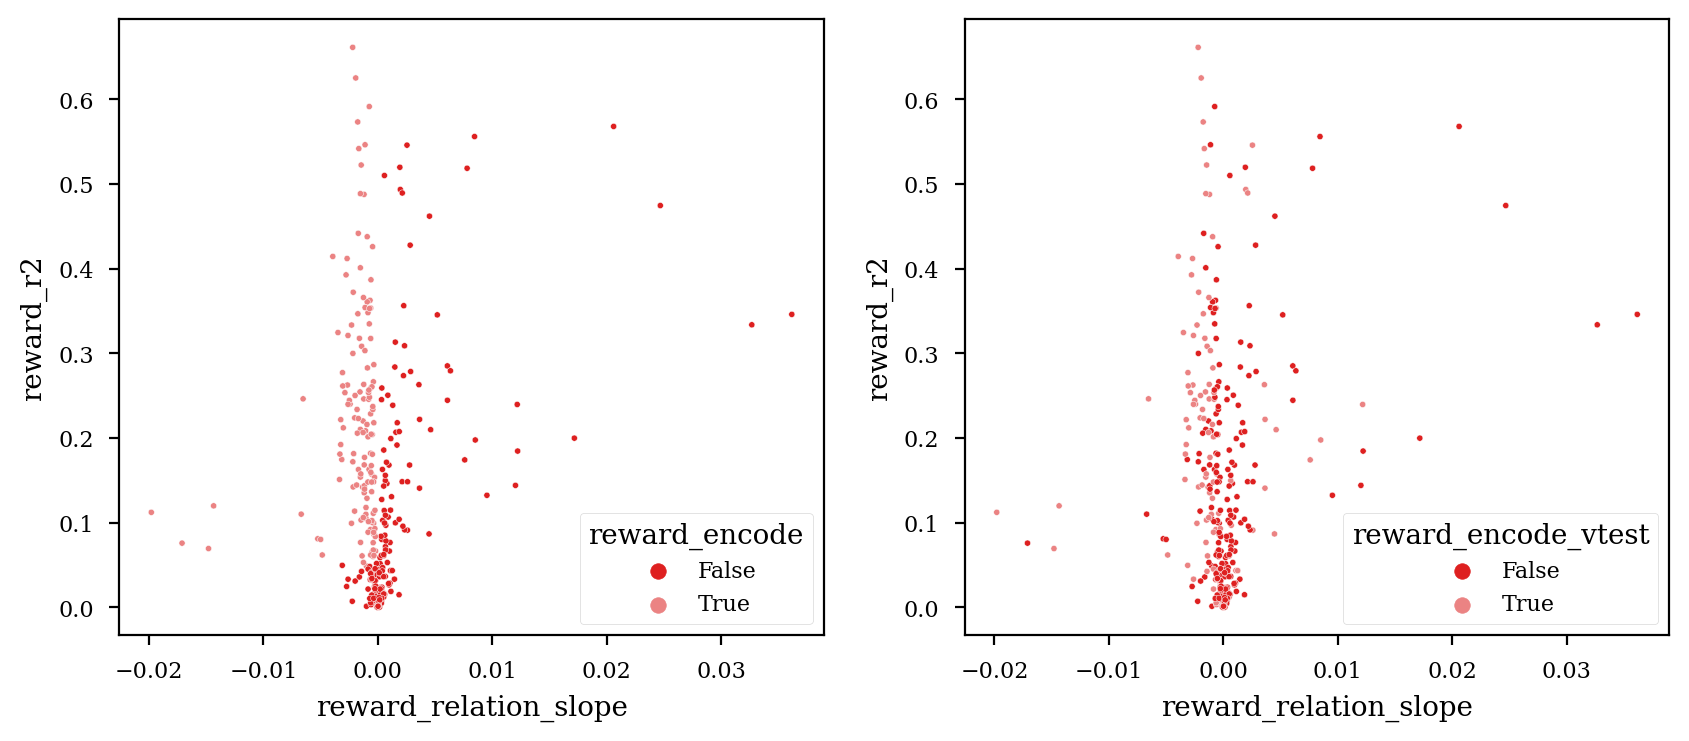

In [198]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(data=label_df,x="reward_relation_slope",y="reward_r2",hue="reward_encode",s=5,ax=ax[0])
sns.scatterplot(data=label_df,x="reward_relation_slope",y="reward_r2",hue="reward_encode_vtest",s=5,ax=ax[1])

## peaks method of detection of reward assembly

In [199]:
for basepath_i, basepath in enumerate(label_df.basepath.unique()):

    label_df_current = label_df.query("basepath==@basepath")

    peak_locs = tc[basepath_i].index[np.argmax(tc[basepath_i].values, axis=0)]

    right_peaks = peak_locs[(label_df_current.direction_label == "right_epochs").values]
    left_peaks = peak_locs[(label_df_current.direction_label == "left_epochs").values]

    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"peak_loc"] = right_peaks
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"peak_loc"] = left_peaks

    x_reward_right = label_df_current.x_reward_right.iloc[0]
    reward_assembly = (right_peaks > x_reward_right - 25) & (right_peaks < x_reward_right + 50)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"reward_assembly"] = reward_assembly
    
    x_reward_left = label_df_current.x_reward_left.iloc[0]
    reward_assembly = (left_peaks > x_reward_left - 25) & (left_peaks < x_reward_left + 50)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"reward_assembly"] = reward_assembly
    
    # adding decision assembly
    x_decision_right = label_df_current.x_decision.iloc[0]
    decision_assembly = (right_peaks > x_decision_right - 25) & (right_peaks < x_decision_right + 25)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"decision_assembly"] = decision_assembly
    
    x_decision_left = label_df_current.x_decision.iloc[0]
    decision_assembly = (left_peaks > x_decision_left - 25) & (left_peaks < x_decision_left + 25)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"decision_assembly"] = decision_assembly
    

## show examples from first session of reward and decision point assemblies

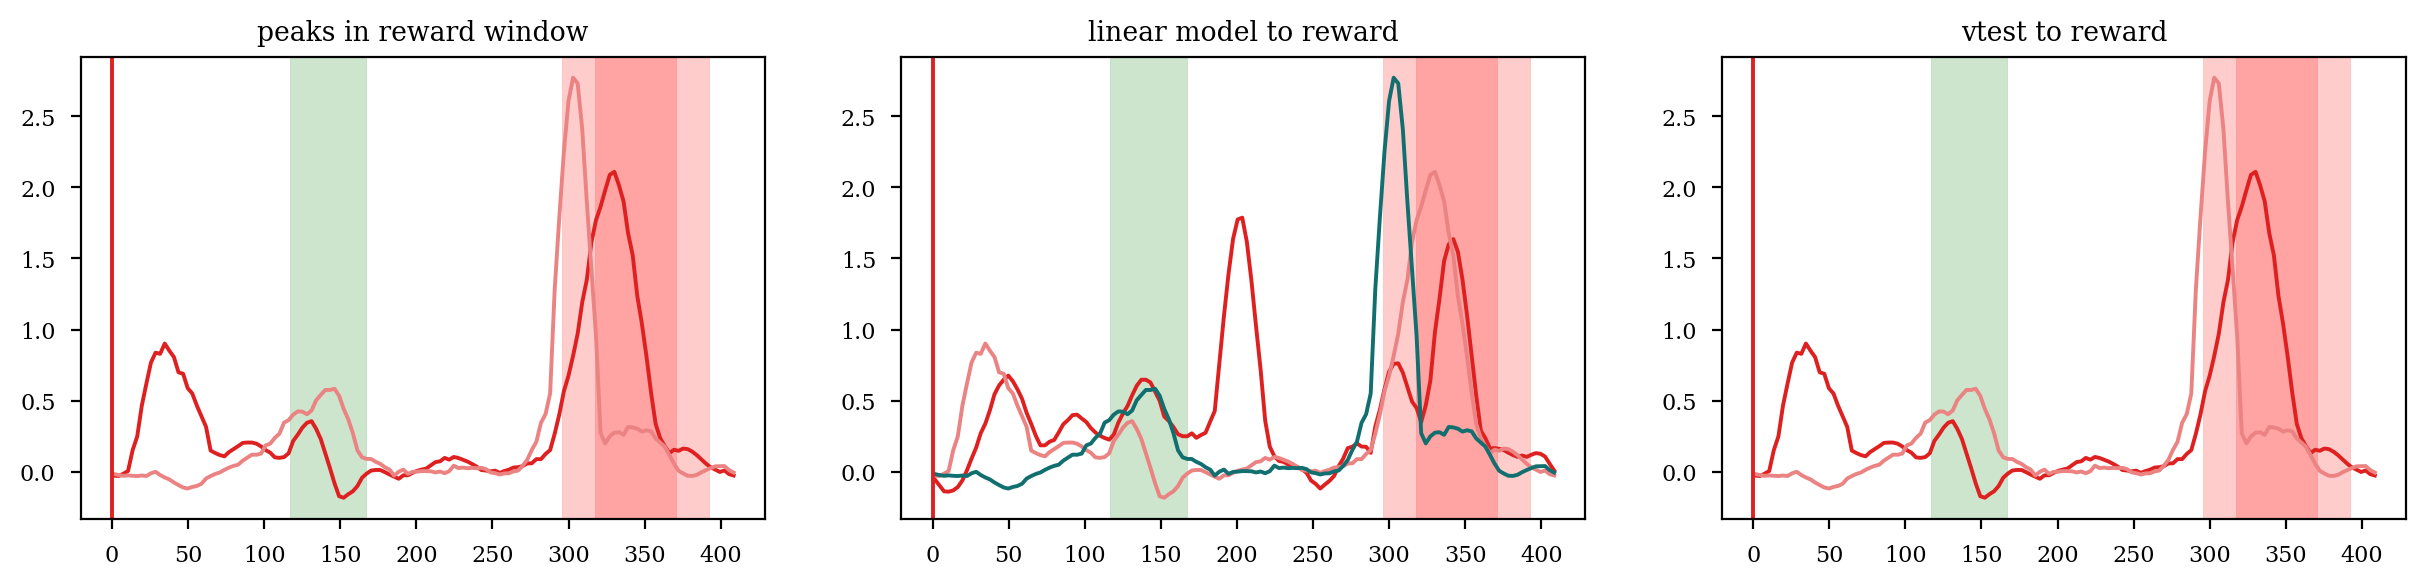

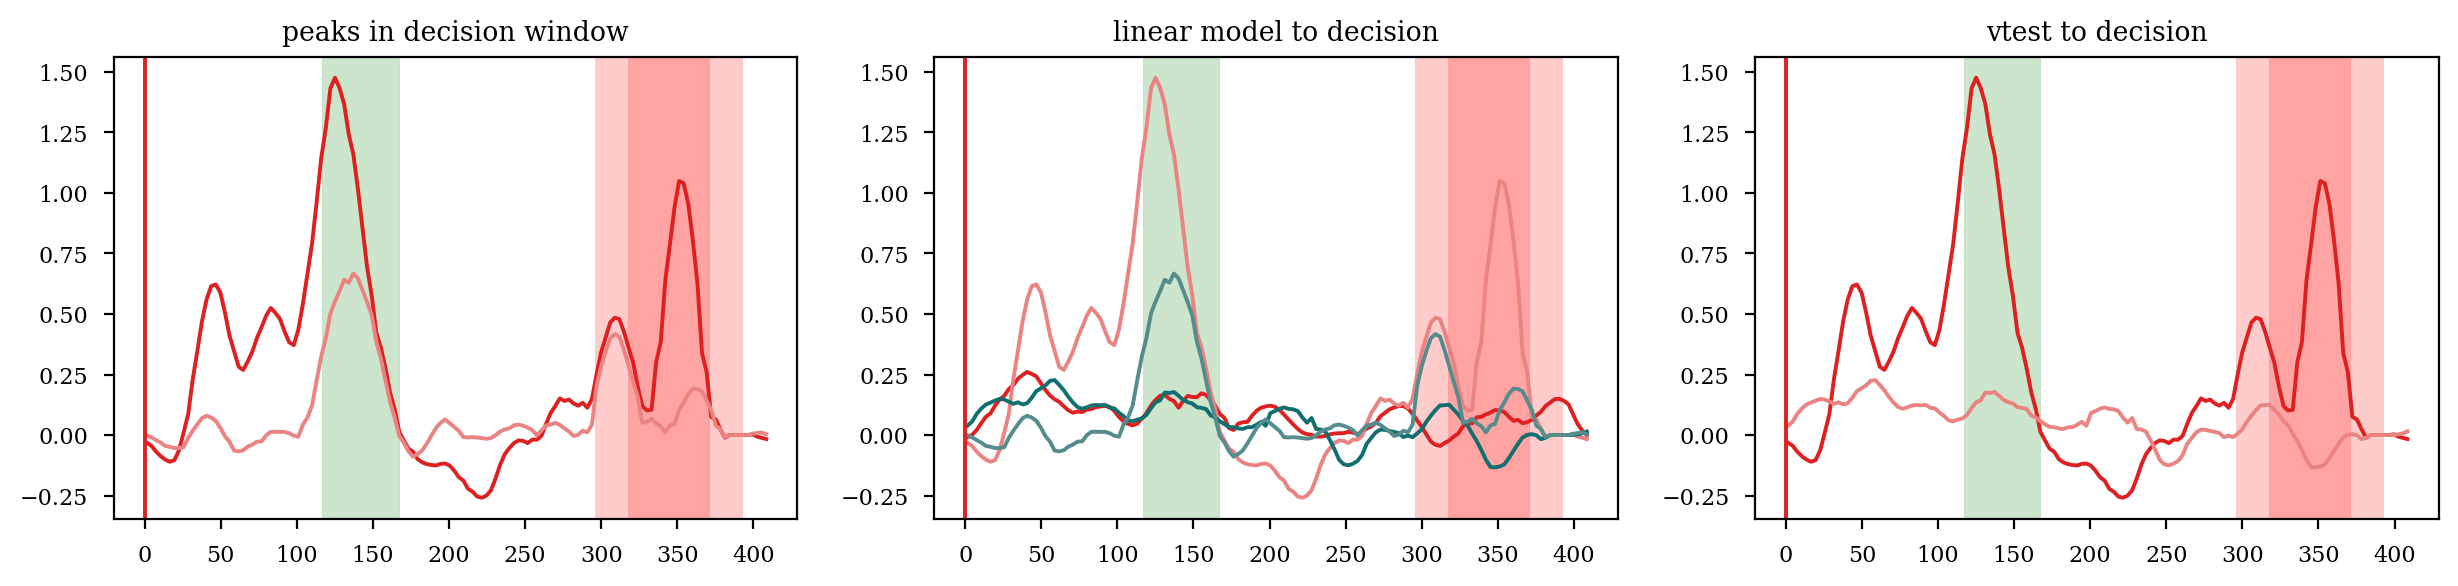

In [200]:
basepath = 'Z:\Data\AYAold\AYA10\day12'
label_df_current = label_df.query("basepath==@basepath")

fig,ax = plt.subplots(1,3,figsize=(15,3))

tc[0].iloc[:,label_df_current.reward_assembly.values == True].plot(ax=ax[0],legend=False)
ax[0].set_title("peaks in reward window")

tc[0].iloc[:,label_df_current.reward_encode.values == True].plot(ax=ax[1],legend=False)
ax[1].set_title("linear model to reward")

tc[0].iloc[:,label_df_current.reward_encode_vtest.values == True].plot(ax=ax[2],legend=False)
ax[2].set_title("vtest to reward")

for i in range(3):
    ax[i].axvline(label_df_current.x_start.iloc[0])
    ax[i].axvspan(label_df_current.x_decision.iloc[0]-25,label_df_current.x_decision.iloc[0]+25,alpha=0.2,color="g")
    ax[i].axvspan(label_df_current.x_reward_right.iloc[0]-25,label_df_current.x_reward_right.iloc[0]+50,alpha=0.2,color="r")
    ax[i].axvspan(label_df_current.x_reward_left.iloc[0]-25,label_df_current.x_reward_left.iloc[0]+50,alpha=0.2,color="r")


basepath = 'Z:\Data\AYAold\AYA10\day12'
label_df_current = label_df.query("basepath==@basepath")

fig,ax = plt.subplots(1,3,figsize=(15,3))

tc[0].iloc[:,label_df_current.decision_assembly.values == True].plot(ax=ax[0],legend=False)
ax[0].set_title("peaks in decision window")

tc[0].iloc[:,label_df_current.decision_encode.values == True].plot(ax=ax[1],legend=False)
ax[1].set_title("linear model to decision")

tc[0].iloc[:,label_df_current.decision_encode_vtest.values == True].plot(ax=ax[2],legend=False)
ax[2].set_title("vtest to decision")

for i in range(3):
    ax[i].axvline(label_df_current.x_start.iloc[0])
    ax[i].axvspan(label_df_current.x_decision.iloc[0]-25,label_df_current.x_decision.iloc[0]+25,alpha=0.2,color="g")
    ax[i].axvspan(label_df_current.x_reward_right.iloc[0]-25,label_df_current.x_reward_right.iloc[0]+50,alpha=0.2,color="r")
    ax[i].axvspan(label_df_current.x_reward_left.iloc[0]-25,label_df_current.x_reward_left.iloc[0]+50,alpha=0.2,color="r")


## using model where if the peak is within range

,cross_region_label,n_reward_assembly,n_assembly,prop_reward_assembly,constant
0,deep_mec,2.0,38.0,0.052632,1
1,deep_pfc,74.0,164.0,0.451220,1
2,sup_mec,5.0,22.0,0.227273,1
3,sup_pfc,48.0,136.0,0.352941,1


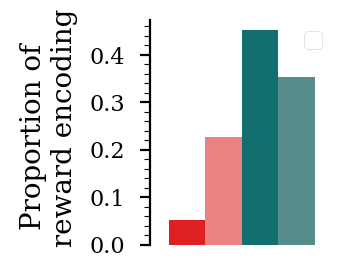

In [224]:
reward_prop_df = label_df.groupby("cross_region_label").apply(
    lambda x: pd.Series(
        {
            "n_reward_assembly": x.reward_assembly.sum(),
            "n_assembly": len(x),
            "prop_reward_assembly": x.reward_assembly.sum() / len(x),
        }
    )
).reset_index()
reward_prop_df["constant"] = 1
display(reward_prop_df)

group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}

sns.set_palette(sns.color_palette(group_colors.values()))

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(2, 1)), edgecolor=None
)
sns.barplot(data=reward_prop_df,x="constant",y="prop_reward_assembly",hue="cross_region_label",hue_order=group_colors.keys(),saturation=1)

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Proportion of \n reward encoding")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

plt.savefig(
    os.path.join(fig_save_path, "cross_region_assembly_ratemap_reward_rep_tmaze.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [225]:
reward_prop_df.n_assembly.sum()


360.0

In [226]:
label_df.groupby(["basepath","assembly_n"]).apply(lambda x: x.assembly_n.nunique()).reset_index().rename(columns={0:"n_unique_assemblies"}).n_unique_assemblies.sum()


180

In [203]:
label_df_basepath_prop = label_df.groupby(["basepath", "cross_region_label"]).apply(
    lambda x: pd.Series({"prop_reward_assembly":x.reward_assembly.sum() / len(x),"n_assemblies":len(x)})
).reset_index()
label_df_basepath_prop.head()

,basepath,cross_region_label,prop_reward_assembly,n_assemblies
0,Z:\Data\AYAold\AYA10\day12,deep_mec,0.100000,10.0
1,Z:\Data\AYAold\AYA10\day12,sup_mec,0.500000,2.0
2,Z:\Data\FujisawaS\EE\EE0622fm,deep_pfc,0.400000,10.0
3,Z:\Data\FujisawaS\EE\EE0622fm,sup_pfc,0.416667,12.0
4,Z:\Data\FujisawaS\EE\EE0627fm,deep_pfc,0.500000,22.0


In [204]:
import statsmodels.api as sm

df_prop = label_df_basepath_prop.query("cross_region_label=='deep_pfc' or cross_region_label=='sup_pfc'").copy()
df_prop = sm.add_constant(df_prop)
df_prop["label_binary"] = (df_prop["cross_region_label"] == "deep_pfc") * 1

logit_model = sm.GLM(
    df_prop.prop_reward_assembly,
    df_prop[["const", "label_binary"]],
    freq_weights=df_prop.n_assemblies,
    family=sm.families.Binomial(),
)
result = logit_model.fit()

print(result.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     prop_reward_assembly   No. Observations:                   23
Model:                              GLM   Df Residuals:                      298
Model Family:                  Binomial   Df Model:                            1
Link Function:                    Logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -139.72
Date:                  Fri, 03 Mar 2023   Deviance:                       40.960
Time:                          11:06:03   Pearson chi2:                     35.0
No. Iterations:                       3   Pseudo R-squ. (CS):             0.1219
Covariance Type:              nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.6061     

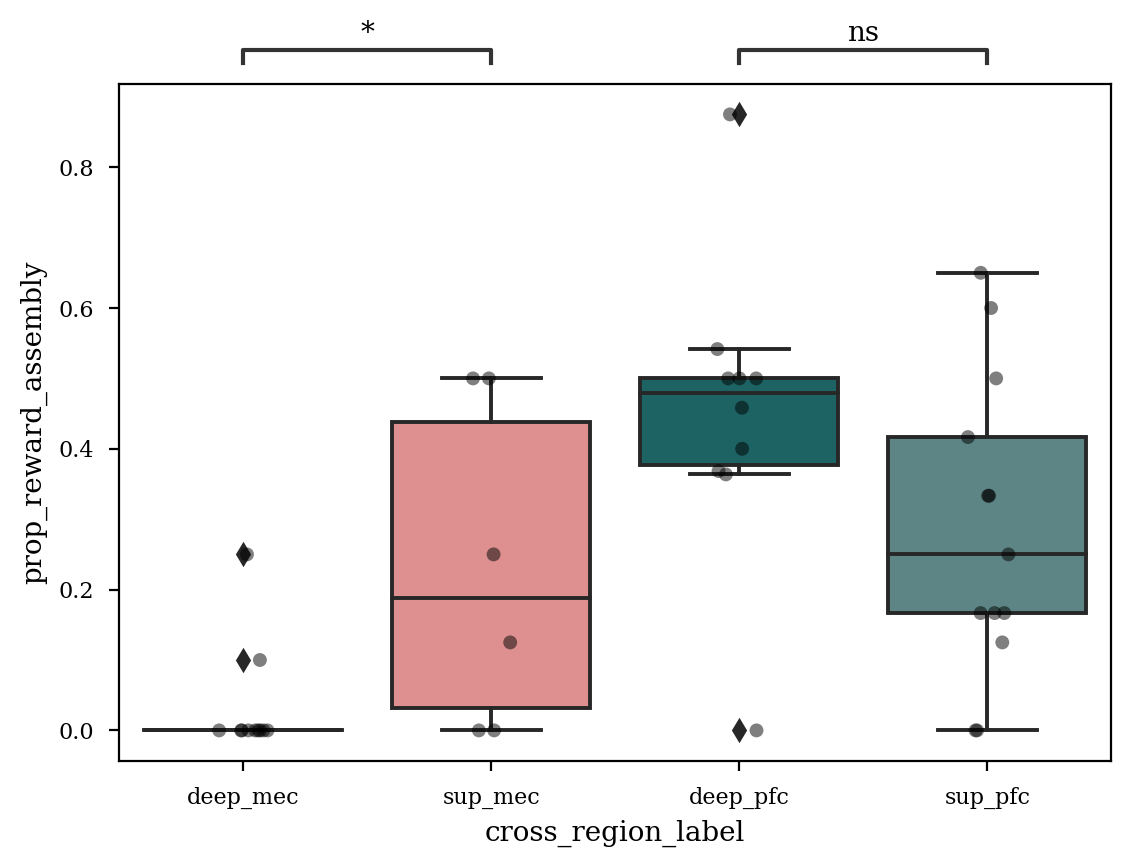

In [205]:
def annotate_this(df, x, y, ax=None, hue=None):
    if ax is None:
        ax = plt.gca()
    box_pairs = [("deep_mec", "sup_mec"), ("deep_pfc", "sup_pfc")]
    annotator = Annotator(
        ax,
        box_pairs,
        data=df,
        x=x,
        y=y,
    )
    annotator.configure(
        test="t-test_ind",
        text_format="star",
        loc="outside",
        comparisons_correction=None,
        verbose=0,
    )
    annotator.apply_and_annotate()

sns.boxplot(data=label_df_basepath_prop,x="cross_region_label",y="prop_reward_assembly")
sns.stripplot(data=label_df_basepath_prop,x="cross_region_label",y="prop_reward_assembly",color="k",alpha=0.5)
annotate_this(label_df_basepath_prop, "cross_region_label", "prop_reward_assembly", plt.gca())

### deep/mec vs. sup/mec

In [206]:
count = [
    reward_prop_df.query("cross_region_label == 'deep_mec'").n_reward_assembly.sum(),
    reward_prop_df.query("cross_region_label == 'sup_mec'").n_reward_assembly.sum(),
]
nobs = [
    reward_prop_df.query("cross_region_label == 'deep_mec'").n_assembly.sum(),
    reward_prop_df.query("cross_region_label == 'sup_mec'").n_assembly.sum(),
]
stat, pval = proportions_ztest(count, nobs,alternative="smaller")
stat, pval

(-2.0306654860546964, 0.02114446988328663)

### deep/pfc vs. sup/pfc

In [207]:
count = [
    reward_prop_df.query("cross_region_label == 'deep_pfc'").n_reward_assembly.sum(),
    reward_prop_df.query("cross_region_label == 'sup_pfc'").n_reward_assembly.sum(),
]
nobs = [
    reward_prop_df.query("cross_region_label == 'deep_pfc'").n_assembly.sum(),
    reward_prop_df.query("cross_region_label == 'sup_pfc'").n_assembly.sum(),
]
stat, pval = proportions_ztest(count, nobs, alternative="larger")
stat, pval

(1.7251222734026619, 0.042252719659913125)

## using linear model to classify

,cross_region_label,n_reward_assembly,n_assembly,prop_reward_assembly,constant
0,deep_mec,5.0,38.0,0.131579,1
1,deep_pfc,76.0,164.0,0.463415,1
2,sup_mec,9.0,22.0,0.409091,1
3,sup_pfc,54.0,136.0,0.397059,1


Text(0.5, 0, '')

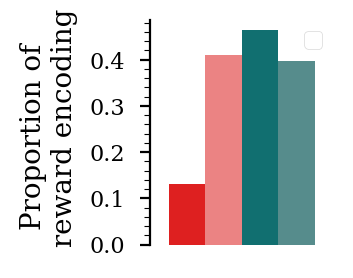

In [208]:
reward_prop_df_v2 = label_df.groupby("cross_region_label").apply(
    lambda x: pd.Series(
        {
            "n_reward_assembly": x.reward_encode.sum(),
            "n_assembly": len(x),
            "prop_reward_assembly": x.reward_encode.sum() / len(x),
        }
    )
).reset_index()
reward_prop_df_v2["constant"] = 1
display(reward_prop_df_v2)

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(2, 1)), edgecolor=None
)
sns.barplot(
    data=reward_prop_df_v2,
    x="constant",
    y="prop_reward_assembly",
    hue="cross_region_label",
    hue_order=group_colors.keys(),
    saturation=1,
)

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Proportion of \n reward encoding")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")


### deep/mec vs. sup/mec

In [209]:
count = [
    reward_prop_df_v2.query("cross_region_label == 'deep_mec'").n_reward_assembly.sum(),
    reward_prop_df_v2.query("cross_region_label == 'sup_mec'").n_reward_assembly.sum(),
]
nobs = [
    reward_prop_df_v2.query("cross_region_label == 'deep_mec'").n_assembly.sum(),
    reward_prop_df_v2.query("cross_region_label == 'sup_mec'").n_assembly.sum(),
]
stat, pval = proportions_ztest(count, nobs,alternative="smaller")
stat, pval

(-2.4491621419334137, 0.007159448691681584)

### deep/pfc vs. sup/pfc

In [210]:
count = [
    reward_prop_df_v2.query("cross_region_label == 'deep_pfc'").n_reward_assembly.sum(),
    reward_prop_df_v2.query("cross_region_label == 'sup_pfc'").n_reward_assembly.sum(),
]
nobs = [
    reward_prop_df_v2.query("cross_region_label == 'deep_pfc'").n_assembly.sum(),
    reward_prop_df_v2.query("cross_region_label == 'sup_pfc'").n_assembly.sum(),
]
stat, pval = proportions_ztest(count, nobs,alternative="larger")
stat, pval

(1.154608705611195, 0.12412535002842084)

## Using circular model to classify

,cross_region_label,n_reward_assembly,n_assembly,prop_reward_assembly,constant
0,deep_mec,5.0,38.0,0.131579,1
1,deep_pfc,46.0,164.0,0.280488,1
2,sup_mec,5.0,22.0,0.227273,1
3,sup_pfc,49.0,136.0,0.360294,1


Text(0.5, 0, '')

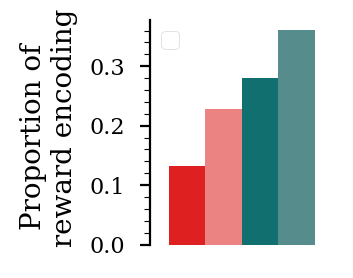

In [211]:
reward_prop_df_v3 = label_df.groupby("cross_region_label").apply(
    lambda x: pd.Series(
        {
            "n_reward_assembly": x.reward_encode_vtest.sum(),
            "n_assembly": len(x),
            "prop_reward_assembly": x.reward_encode_vtest.sum() / len(x),
        }
    )
).reset_index()
reward_prop_df_v3["constant"] = 1
display(reward_prop_df_v3)

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(2, 1)), edgecolor=None
)
sns.barplot(
    data=reward_prop_df_v3,
    x="constant",
    y="prop_reward_assembly",
    hue="cross_region_label",
    hue_order=group_colors.keys(),
    saturation=1,
)

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Proportion of \n reward encoding")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

In [212]:
count = [
    reward_prop_df_v3.query("cross_region_label == 'deep_mec'").n_reward_assembly.sum(),
    reward_prop_df_v3.query("cross_region_label == 'sup_mec'").n_reward_assembly.sum(),
]
nobs = [
    reward_prop_df_v3.query("cross_region_label == 'deep_mec'").n_assembly.sum(),
    reward_prop_df_v3.query("cross_region_label == 'sup_mec'").n_assembly.sum(),
]
stat, pval = proportions_ztest(count, nobs,alternative="smaller")
stat, pval

(-0.958467676597046, 0.16891349158302887)

In [213]:
count = [
    reward_prop_df_v3.query("cross_region_label == 'deep_pfc'").n_reward_assembly.sum(),
    reward_prop_df_v3.query("cross_region_label == 'sup_pfc'").n_reward_assembly.sum(),
]
nobs = [
    reward_prop_df_v3.query("cross_region_label == 'deep_pfc'").n_assembly.sum(),
    reward_prop_df_v3.query("cross_region_label == 'sup_pfc'").n_assembly.sum(),
]
stat, pval = proportions_ztest(count, nobs,alternative="larger")
stat, pval

(-1.47928045199117, 0.9304673124258722)

# decision point encoding

### peak method

,cross_region_label,n_decision_assembly,n_assembly,prop_decision_assembly,constant
0,deep_mec,5.0,38.0,0.131579,1
1,deep_pfc,19.0,164.0,0.115854,1
2,sup_mec,3.0,22.0,0.136364,1
3,sup_pfc,17.0,136.0,0.125000,1


Text(0.5, 0, '')

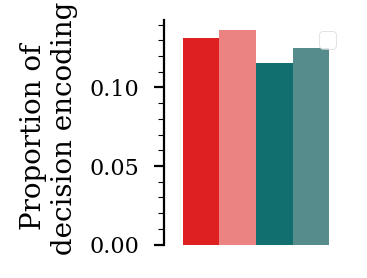

In [214]:
decision_prop_df = label_df.groupby("cross_region_label").apply(
    lambda x: pd.Series(
        {
            "n_decision_assembly": x.decision_assembly.sum(),
            "n_assembly": len(x),
            "prop_decision_assembly": x.decision_assembly.sum() / len(x),
        }
    )
).reset_index()
decision_prop_df["constant"] = 1
display(decision_prop_df)


fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(2, 1)), edgecolor=None
)
sns.barplot(
    data=decision_prop_df,
    x="constant",
    y="prop_decision_assembly",
    hue="cross_region_label",
    hue_order=group_colors.keys(),
    saturation=1,
)

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Proportion of \n decision encoding")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

In [215]:
count = [
    decision_prop_df.query("cross_region_label == 'deep_mec'").n_decision_assembly.sum(),
    decision_prop_df.query("cross_region_label == 'sup_mec'").n_decision_assembly.sum(),
]
nobs = [
    decision_prop_df.query("cross_region_label == 'deep_mec'").n_assembly.sum(),
    decision_prop_df.query("cross_region_label == 'sup_mec'").n_assembly.sum(),
]
stat, pval = proportions_ztest(count, nobs,alternative="smaller")
stat, pval

(-0.052539485125375936, 0.4790494170921909)

In [216]:
count = [
    decision_prop_df.query("cross_region_label == 'deep_pfc'").n_decision_assembly.sum(),
    decision_prop_df.query("cross_region_label == 'sup_pfc'").n_decision_assembly.sum(),
]
nobs = [
    decision_prop_df.query("cross_region_label == 'deep_pfc'").n_assembly.sum(),
    decision_prop_df.query("cross_region_label == 'sup_pfc'").n_assembly.sum(),
]
stat, pval = proportions_ztest(count, nobs,alternative="larger")
stat, pval

(-0.2426868265628351, 0.5958759933489854)

### linear model to classify

,cross_region_label,n_decision_assembly,n_assembly,prop_decision_assembly,constant
0,deep_mec,13.0,38.0,0.342105,1
1,deep_pfc,31.0,164.0,0.189024,1
2,sup_mec,8.0,22.0,0.363636,1
3,sup_pfc,29.0,136.0,0.213235,1


Text(0.5, 0, '')

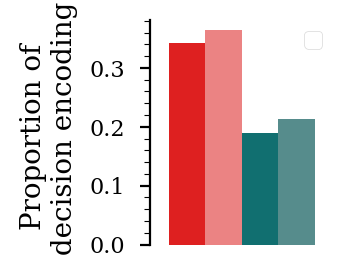

In [217]:
decision_prop_df = label_df.groupby("cross_region_label").apply(
    lambda x: pd.Series(
        {
            "n_decision_assembly": x.decision_encode.sum(),
            "n_assembly": len(x),
            "prop_decision_assembly": x.decision_encode.sum() / len(x),
        }
    )
).reset_index()
decision_prop_df["constant"] = 1
display(decision_prop_df)


fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(2, 1)), edgecolor=None
)
sns.barplot(
    data=decision_prop_df,
    x="constant",
    y="prop_decision_assembly",
    hue="cross_region_label",
    hue_order=group_colors.keys(),
    saturation=1,
)

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Proportion of \n decision encoding")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

In [218]:
count = [
    decision_prop_df.query("cross_region_label == 'deep_mec'").n_decision_assembly.sum(),
    decision_prop_df.query("cross_region_label == 'sup_mec'").n_decision_assembly.sum(),
]
nobs = [
    decision_prop_df.query("cross_region_label == 'deep_mec'").n_assembly.sum(),
    decision_prop_df.query("cross_region_label == 'sup_mec'").n_assembly.sum(),
]
stat, pval = proportions_ztest(count, nobs,alternative="smaller")
stat, pval

(-0.16850121652856798, 0.4330944933516333)

In [219]:
count = [
    decision_prop_df.query("cross_region_label == 'deep_pfc'").n_decision_assembly.sum(),
    decision_prop_df.query("cross_region_label == 'sup_pfc'").n_decision_assembly.sum(),
]
nobs = [
    decision_prop_df.query("cross_region_label == 'deep_pfc'").n_assembly.sum(),
    decision_prop_df.query("cross_region_label == 'sup_pfc'").n_assembly.sum(),
]
stat, pval = proportions_ztest(count, nobs,alternative="larger")
stat, pval

(-0.5218933498135675, 0.6991277055903904)

## Using circular model to classify

,cross_region_label,n_decision_assembly,n_assembly,prop_decision_assembly,constant
0,deep_mec,7.0,38.0,0.184211,1
1,deep_pfc,19.0,164.0,0.115854,1
2,sup_mec,8.0,22.0,0.363636,1
3,sup_pfc,21.0,136.0,0.154412,1


Text(0.5, 0, '')

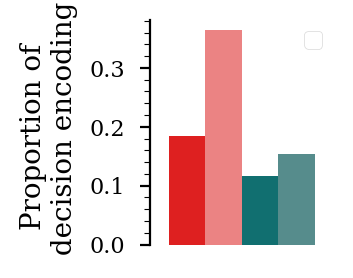

In [220]:
decision_prop_df = label_df.groupby("cross_region_label").apply(
    lambda x: pd.Series(
        {
            "n_decision_assembly": x.decision_encode_vtest.sum(),
            "n_assembly": len(x),
            "prop_decision_assembly": x.decision_encode_vtest.sum() / len(x),
        }
    )
).reset_index()
decision_prop_df["constant"] = 1
display(decision_prop_df)


fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(2, 1)), edgecolor=None
)
sns.barplot(
    data=decision_prop_df,
    x="constant",
    y="prop_decision_assembly",
    hue="cross_region_label",
    hue_order=group_colors.keys(),
    saturation=1,
)

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Proportion of \n decision encoding")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

In [221]:
count = [
    decision_prop_df.query("cross_region_label == 'deep_mec'").n_decision_assembly.sum(),
    decision_prop_df.query("cross_region_label == 'sup_mec'").n_decision_assembly.sum(),
]
nobs = [
    decision_prop_df.query("cross_region_label == 'deep_mec'").n_assembly.sum(),
    decision_prop_df.query("cross_region_label == 'sup_mec'").n_assembly.sum(),
]
stat, pval = proportions_ztest(count, nobs,alternative="smaller")
stat, pval

(-1.546720562224365, 0.06096532130445176)

In [222]:
count = [
    decision_prop_df.query("cross_region_label == 'deep_pfc'").n_decision_assembly.sum(),
    decision_prop_df.query("cross_region_label == 'sup_pfc'").n_decision_assembly.sum(),
]
nobs = [
    decision_prop_df.query("cross_region_label == 'deep_pfc'").n_assembly.sum(),
    decision_prop_df.query("cross_region_label == 'sup_pfc'").n_assembly.sum(),
]
stat, pval = proportions_ztest(count, nobs,alternative="larger")
stat, pval

(-0.9780274197665688, 0.835969618589298)

In [345]:
# df_peak.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_df_peak.csv")


## splitter assemblies

* locate peak value in central arm
* could find assembly with peak in central,
* could find assembly with 50% difference left right.

In [51]:
for basepath_i, basepath in enumerate(label_df.basepath.unique()):

    label_df_current = label_df.query("basepath==@basepath")
    central_arm_idx = tc[basepath_i].index < label_df_current.x_decision.iloc[0]

    right_idx = (label_df_current.direction_label == "right_epochs").values
    peak_vals = tc[basepath_i].iloc[central_arm_idx,right_idx].max()
    peak_loc = np.argmax(tc[basepath_i].iloc[central_arm_idx,right_idx].values,axis=0)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"central_arm_peak_value"] = peak_vals.values
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"central_arm_peak_loc"] = peak_loc

    left_idx = (label_df_current.direction_label == "left_epochs").values
    peak_vals = tc[basepath_i].iloc[central_arm_idx,left_idx].max()
    peak_loc = np.argmax(tc[basepath_i].iloc[central_arm_idx,left_idx].values,axis=0)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"central_arm_peak_value"] = peak_vals.values
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"central_arm_peak_loc"] = peak_loc

    right_tc = tc[basepath_i].iloc[central_arm_idx,right_idx].values
    left_tc = tc[basepath_i].iloc[central_arm_idx,left_idx].values
    corrs = []
    for i in range(right_tc.shape[1]):
        corrs.append(np.corrcoef(right_tc[:,i],left_tc[:,i])[0,1])
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"spatial_corr"] = np.array(corrs)
label_df["constant"] = 1
label_df

,assembly_n,direction_label,cross_region_label,x_start,x_decision,x_reward_left,x_reward_right,basepath,animal_id,reward_r2,...,reward_encode,pval_vtest,v_vtest,reward_encode_vtest,peak_loc,reward_assembly,central_arm_peak_value,central_arm_peak_loc,spatial_corr,constant
0,0,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.010955,...,False,0.394171,1.108049,False,91.948529,False,0.589420,30.0,-0.087121,1
1,1,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.014997,...,False,0.050968,5.643891,False,16.580882,False,0.894259,5.0,0.835057,1
2,2,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.048857,...,True,0.346635,2.094127,False,203.492647,False,0.677052,16.0,0.619332,1
3,3,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.076686,...,True,0.000002,22.147151,True,330.110294,True,0.902268,11.0,0.899154,1
4,4,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.259101,...,False,0.882103,-2.854057,False,40.698529,False,0.260494,13.0,0.654524,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,1,left_epochs,deep_mec,0.0,87.984048,257.212112,257.810041,Z:\Data\Kenji\ec014.427_456,ec014,0.143275,...,False,0.725743,-0.839903,False,130.500000,False,0.195970,11.0,NaN,1
356,0,right_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.001315,...,False,0.214971,0.643978,False,19.500000,False,0.073922,6.0,0.610312,1
357,1,right_epochs,sup_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.034110,...,False,0.831988,-2.072276,False,187.500000,False,0.155657,31.0,-0.439393,1
358,0,left_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.040944,...,False,0.244372,0.662531,False,175.500000,False,0.080721,11.0,NaN,1


## spatial correlation

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_deep_pfc vs. 1_sup_pfc: t-test independent samples, P_val:5.966e-01 t=-5.304e-01
1_deep_mec vs. 1_sup_mec: t-test independent samples, P_val:9.000e-01 t=1.268e-01
1_sup_mec vs. 1_sup_pfc: t-test independent samples, P_val:1.540e-01 t=1.440e+00
1_deep_mec vs. 1_deep_pfc: t-test independent samples, P_val:1.492e-02 t=2.478e+00


(<AxesSubplot: ylabel='center arm spatial corr (r)'>,
  <statannotations.Annotation.Annotation at 0x1df681db2b0>])

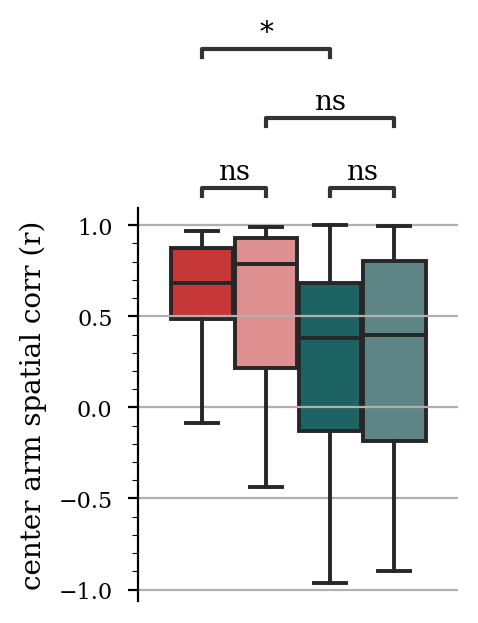

In [52]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
sns.boxplot(data=label_df,hue="cross_region_label",x="constant",y="spatial_corr",showfliers=False)
# sns.stripplot(data=label_df,hue="cross_region_label",x="constant",y="spatial_corr",dodge=True,color="k",s=2)
# plt.yscale("log")
# plt.axhline(1,color="k",linestyle="--",zorder=-100)
sns.despine(bottom=True)
# plt.legend("")
plt.gca().legend().set_visible(False)

plt.ylabel("center arm spatial corr (r)")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")
plt.grid()

box_pairs = [
    ((1, "deep_mec"), (1, "sup_mec")),
    ((1, "deep_pfc"), (1, "sup_pfc")),
    ((1, "deep_pfc"), (1, "deep_mec")),
    ((1, "sup_pfc"), (1, "sup_mec")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=label_df,
    x="constant",
    y="spatial_corr",
    hue="cross_region_label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

## pivot table to look at left and right assembly response

In [53]:
label_df_pivot = label_df.pivot(index=["basepath","assembly_n","cross_region_label"],columns="direction_label", values="central_arm_peak_value").reset_index()
# label_df_pivot["left_right_ratio"] = label_df_pivot.left_epochs / label_df_pivot.right_epochs
label_df_pivot["constant"] = 1

label_df_pivot

direction_label,basepath,assembly_n,cross_region_label,left_epochs,right_epochs,constant
0,Z:\Data\AYAold\AYA10\day12,0,deep_mec,0.580851,0.589420,1
1,Z:\Data\AYAold\AYA10\day12,1,deep_mec,0.644143,0.894259,1
2,Z:\Data\AYAold\AYA10\day12,2,deep_mec,1.476069,0.677052,1
3,Z:\Data\AYAold\AYA10\day12,3,deep_mec,1.679355,0.902268,1
4,Z:\Data\AYAold\AYA10\day12,4,deep_mec,0.226888,0.260494,1
...,...,...,...,...,...,...
175,Z:\Data\Kenji\ec014.398_425,0,deep_mec,0.091439,0.397176,1
176,Z:\Data\Kenji\ec014.427_456,0,deep_mec,0.139694,0.087579,1
177,Z:\Data\Kenji\ec014.427_456,1,deep_mec,0.195970,0.239149,1
178,Z:\Data\Kenji\ec016.479_487,0,deep_mec,0.080721,0.073922,1


In [54]:
max_min_ratio = []
for temp_df in label_df_pivot.itertuples():

    other_dir = min([temp_df.left_epochs, temp_df.right_epochs])
    preferred_dir = max([temp_df.left_epochs, temp_df.right_epochs])

    max_min_ratio.append(
        ((preferred_dir - other_dir) / (preferred_dir + other_dir)) * 100
    )

    # max_min_ratio.append(max([temp_df.left_epochs,temp_df.right_epochs]) / min([temp_df.left_epochs,temp_df.right_epochs]))
label_df_pivot["max_min_ratio"] = np.array(max_min_ratio)

label_df_pivot


direction_label,basepath,assembly_n,cross_region_label,left_epochs,right_epochs,constant,max_min_ratio
0,Z:\Data\AYAold\AYA10\day12,0,deep_mec,0.580851,0.589420,1,0.732229
1,Z:\Data\AYAold\AYA10\day12,1,deep_mec,0.644143,0.894259,1,16.258162
2,Z:\Data\AYAold\AYA10\day12,2,deep_mec,1.476069,0.677052,1,37.109727
3,Z:\Data\AYAold\AYA10\day12,3,deep_mec,1.679355,0.902268,1,30.100733
4,Z:\Data\AYAold\AYA10\day12,4,deep_mec,0.226888,0.260494,1,6.895355
...,...,...,...,...,...,...,...
175,Z:\Data\Kenji\ec014.398_425,0,deep_mec,0.091439,0.397176,1,62.572108
176,Z:\Data\Kenji\ec014.427_456,0,deep_mec,0.139694,0.087579,1,22.930834
177,Z:\Data\Kenji\ec014.427_456,1,deep_mec,0.195970,0.239149,1,9.923619
178,Z:\Data\Kenji\ec016.479_487,0,deep_mec,0.080721,0.073922,1,4.396734


<AxesSubplot: >

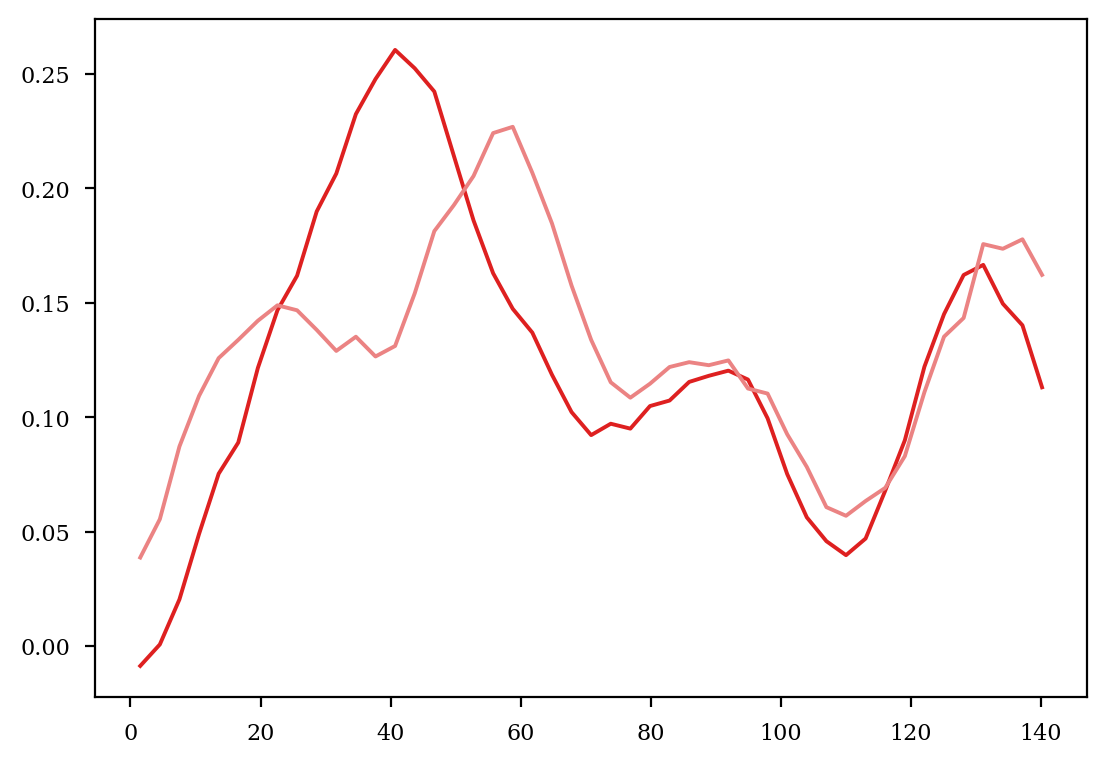

In [55]:
basepath = "Z:\Data\AYAold\AYA10\day12"
basepath_i = np.where(label_df.basepath.unique() == basepath)[0][0]
tc[basepath_i]

label_df_current = label_df.query("basepath==@basepath")
central_arm_idx = tc[basepath_i].index < label_df_current.x_decision.iloc[0]
right_idx = (label_df_current.direction_label == "right_epochs").values

tc[basepath_i].iloc[central_arm_idx,right_idx].iloc[:,4].plot()

central_arm_idx = tc[basepath_i].index < label_df_current.x_decision.iloc[0]
left_idx = (label_df_current.direction_label == "left_epochs").values

tc[basepath_i].iloc[central_arm_idx,left_idx].iloc[:,4].plot()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_deep_pfc vs. 1_sup_pfc: t-test independent samples, P_val:2.424e-01 t=1.174e+00
1_deep_mec vs. 1_sup_mec: t-test independent samples, P_val:2.382e-01 t=1.205e+00
1_sup_mec vs. 1_sup_pfc: t-test independent samples, P_val:1.186e-01 t=-1.578e+00
1_deep_mec vs. 1_deep_pfc: t-test independent samples, P_val:3.110e-01 t=-1.018e+00


(<AxesSubplot: ylabel='assembly strength difference (%)'>,
  <statannotations.Annotation.Annotation at 0x1df681d0ac0>])

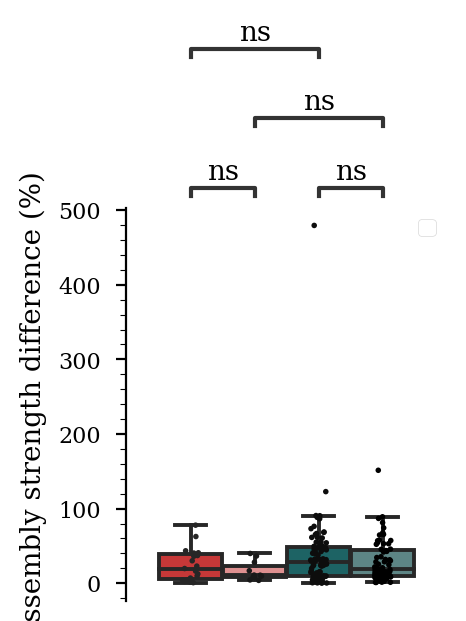

In [56]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
sns.boxplot(data=label_df_pivot,hue="cross_region_label",x="constant",y="max_min_ratio",showfliers=False)
sns.stripplot(data=label_df_pivot,hue="cross_region_label",x="constant",y="max_min_ratio",dodge=True,color="k",s=2)
# plt.yscale("log")
# plt.axhline(1,color="k",linestyle="--",zorder=-100)
sns.despine(bottom=True)
plt.legend("")
plt.ylabel("assembly strength difference (%)")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

box_pairs = [
    ((1, "deep_mec"), (1, "sup_mec")),
    ((1, "deep_pfc"), (1, "sup_pfc")),
    ((1, "deep_pfc"), (1, "deep_mec")),
    ((1, "sup_pfc"), (1, "sup_mec")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=label_df_pivot,
    x="constant",
    y="max_min_ratio",
    hue="cross_region_label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

In [57]:
splitter_prop_df = label_df_pivot.groupby("cross_region_label").apply(
    lambda x: pd.Series(
        {
            "n_splitter_assembly": (x.max_min_ratio > 50).sum(),
            "n_assembly": len(x),
        }
    )
).reset_index()
splitter_prop_df["splitter_prop"] = splitter_prop_df.n_splitter_assembly / splitter_prop_df.n_assembly
splitter_prop_df["constant"] = 1
splitter_prop_df

,cross_region_label,n_splitter_assembly,n_assembly,splitter_prop,constant
0,deep_mec,2,19,0.105263,1
1,deep_pfc,19,82,0.231707,1
2,sup_mec,0,11,0.000000,1
3,sup_pfc,15,68,0.220588,1


Text(0.5, 0, '')

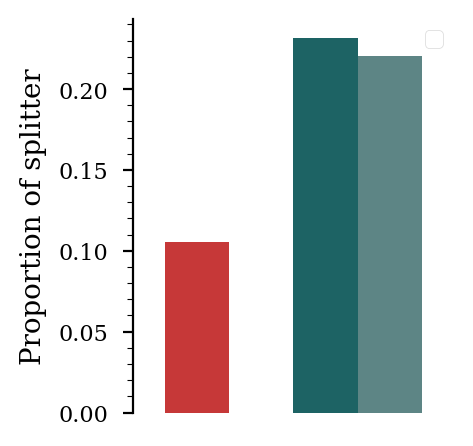

In [58]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
sns.barplot(data=splitter_prop_df,x="constant",y="splitter_prop",hue="cross_region_label",hue_order=group_colors.keys())

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Proportion of splitter")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

## Decision encoding

In [59]:
decision_assembly = []
for basepath_i, basepath in enumerate(label_df.basepath.unique()):

    label_df_current = label_df.query("basepath==@basepath")

    peak_locs = tc[basepath_i].index[np.argmax(tc[basepath_i].values, axis=0)]

    right_peaks = peak_locs[(label_df_current.direction_label == "right_epochs").values]
    left_peaks = peak_locs[(label_df_current.direction_label == "left_epochs").values]

    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"peak_loc"] = right_peaks
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"peak_loc"] = left_peaks

    x_decision_right = label_df_current.x_decision.iloc[0]
    decision_assembly = (right_peaks > x_decision_right - 25) & (right_peaks < x_decision_right + 25)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"decision_assembly"] = decision_assembly
    
    x_decision_left = label_df_current.x_decision.iloc[0]
    decision_assembly = (left_peaks > x_decision_left - 25) & (left_peaks < x_decision_left + 25)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"decision_assembly"] = decision_assembly
label_df

c:\Users\Cornell\anaconda3\envs\ripple_heterogeneity\lib\site-packages\IPython\lib\pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
c:\Users\Cornell\anaconda3\envs\ripple_heterogeneity\lib\site-packages\IPython\core\formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.


,assembly_n,direction_label,cross_region_label,x_start,x_decision,x_reward_left,x_reward_right,basepath,animal_id,reward_r2,...,pval_vtest,v_vtest,reward_encode_vtest,peak_loc,reward_assembly,central_arm_peak_value,central_arm_peak_loc,spatial_corr,constant,decision_assembly
0,0,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.010955,...,0.394171,1.108049,False,91.948529,False,0.589420,30.0,-0.087121,1,False
1,1,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.014997,...,0.050968,5.643891,False,16.580882,False,0.894259,5.0,0.835057,1,False
2,2,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.048857,...,0.346635,2.094127,False,203.492647,False,0.677052,16.0,0.619332,1,False
3,3,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.076686,...,0.000002,22.147151,True,330.110294,True,0.902268,11.0,0.899154,1,False
4,4,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.259101,...,0.882103,-2.854057,False,40.698529,False,0.260494,13.0,0.654524,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,1,left_epochs,deep_mec,0.0,87.984048,257.212112,257.810041,Z:\Data\Kenji\ec014.427_456,ec014,0.143275,...,0.725743,-0.839903,False,130.500000,False,0.195970,11.0,NaN,1,False
356,0,right_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.001315,...,0.214971,0.643978,False,19.500000,False,0.073922,6.0,0.610312,1,False
357,1,right_epochs,sup_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.034110,...,0.831988,-2.072276,False,187.500000,False,0.155657,31.0,-0.439393,1,False
358,0,left_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.040944,...,0.244372,0.662531,False,175.500000,False,0.080721,11.0,NaN,1,False


In [60]:
decision_prop_df = label_df.groupby("cross_region_label").apply(
    lambda x: pd.Series(
        {
            "n_decision_assembly": x.decision_assembly.sum(),
            "n_assembly": len(x),
            "prop_decision_assembly": x.decision_assembly.sum() / len(x),
        }
    )
).reset_index()
decision_prop_df["constant"] = 1
decision_prop_df

,cross_region_label,n_decision_assembly,n_assembly,prop_decision_assembly,constant
0,deep_mec,5.0,38.0,0.131579,1
1,deep_pfc,19.0,164.0,0.115854,1
2,sup_mec,3.0,22.0,0.136364,1
3,sup_pfc,17.0,136.0,0.125000,1


In [61]:
decision_prop_df.n_decision_assembly.sum()

44.0

Text(0.5, 0, '')

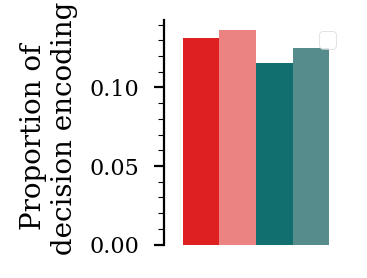

In [62]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(2, 1)), edgecolor=None
)
sns.barplot(data=decision_prop_df,x="constant",y="prop_decision_assembly",hue="cross_region_label",hue_order=group_colors.keys(),saturation=1)

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Proportion of \n decision encoding")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

# plt.savefig(
#     os.path.join(fig_save_path, "cross_region_assembly_ratemap_decision_rep_tmaze.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

In [63]:
count = decision_prop_df.query("cross_region_label=='deep_mec' | cross_region_label=='sup_mec'").n_decision_assembly
nobs = decision_prop_df.query("cross_region_label=='deep_mec' | cross_region_label=='sup_mec'").n_assembly

stat, pval = proportions_ztest(count, nobs, alternative="smaller")
stat, pval

(-0.052539485125375936, 0.4790494170921909)

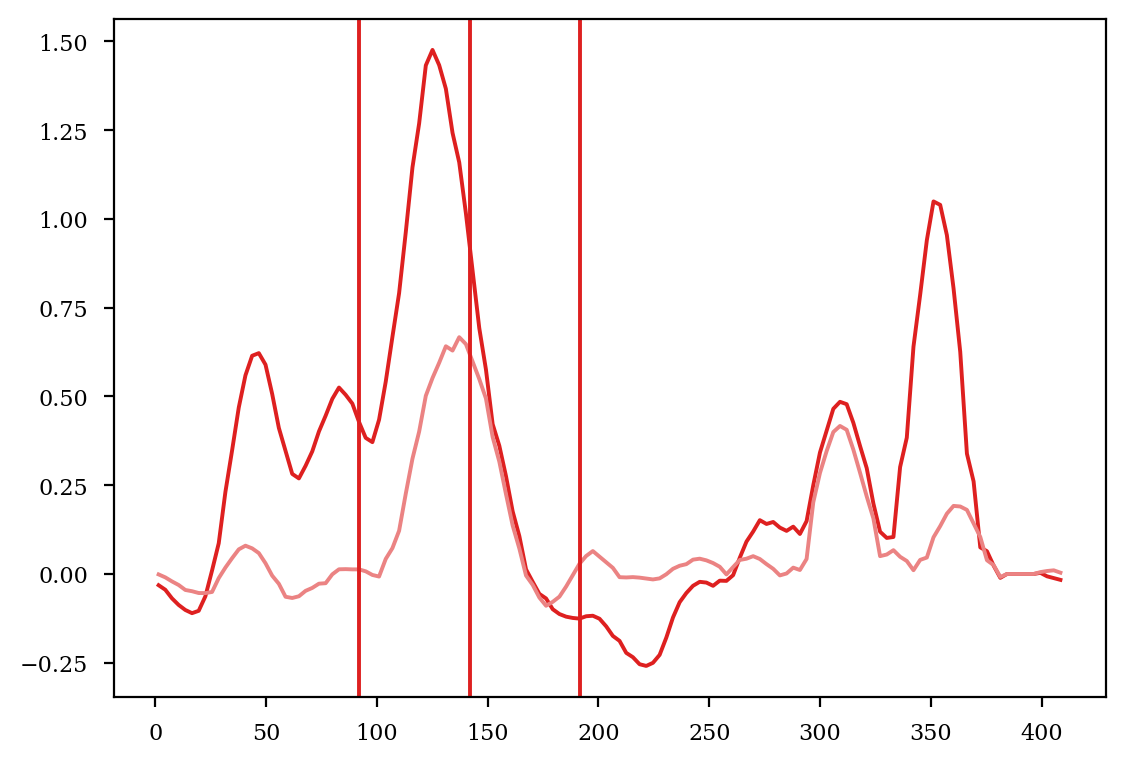

In [65]:
basepath = 'Z:\Data\AYAold\AYA10\day12'
label_df_current = label_df.query("basepath==@basepath")

tc[0].iloc[:,label_df_current.decision_assembly.values == True].plot()
plt.gca().get_legend().remove()

# plt.axvline(label_df_current.x_start.iloc[0])
plt.axvline(label_df_current.x_decision.iloc[0]-50)
plt.axvline(label_df_current.x_decision.iloc[0])
plt.axvline(label_df_current.x_decision.iloc[0]+50)

# plt.axvline(label_df_current.x_reward_left.iloc[0])
# plt.axvline(label_df_current.x_reward_right.iloc[0])

## Testing below

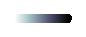

In [25]:
a = np.array([[0,1]])
plt.figure(figsize=(.5, .1))
img = plt.imshow(a, cmap="bone_r")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax,extend='max')
plt.axis("off")
plt.savefig(
    os.path.join(fig_save_path, "bone_r_colorbar.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [191]:
def locate_t_maze_key_locations(current_pos):
    start_pos = (
        current_pos.dropna(subset=["linearized", "x", "y"])
        .query("states==0")
        .sort_values(by="linearized")[["x", "y"]][:10]
        .mean()
        .values
    )
    decision_pos = (
        current_pos.dropna(subset=["linearized", "x", "y"])
        .query("states==0")
        .sort_values(by="linearized", ascending=False)[["x", "y"]][:10]
        .mean()
        .values
    )
    reward_right_pos = start_pos.copy()
    reward_left_pos = start_pos.copy()
    return start_pos, decision_pos, reward_left_pos, reward_right_pos


env = "Mwheel|Tmaze|tmaze"
for basepath in session_df.basepath.unique():

    # if "FujisawaS" in basepath:
    #     continue

    epoch_df = loading.load_epoch(basepath)
    task_idx = assembly_multi_region_pos_maps_tmaze_ind_detect.locate_task_epoch(
        epoch_df, env
    )

    position_df = loading.load_animal_behavior(basepath)

    current_pos = position_df.query(
        "time >= @epoch_df.iloc[@task_idx].startTime & time <= @epoch_df.iloc[@task_idx].stopTime"
    )
    if current_pos.dropna(subset=["x", "y"]).shape[0] == 0:
        continue
    try:
        start_pos, decision_pos, reward_left_pos, reward_right_pos = locate_t_maze_key_locations(current_pos)
    except:
        print(basepath)
    plt.figure()
    sns.scatterplot(data=current_pos,x="x",y="y",s=3,color="grey")
    plt.scatter(start_pos[0],start_pos[1],s=100,label="start_pos")
    plt.scatter(decision_pos[0],decision_pos[1],s=100,label="decision_pos")
    plt.axis("equal")
    plt.title(f"{basepath}, {epoch_df.iloc[task_idx].environment}")
    plt.legend()
    plt.show()

In [145]:
session = r"Z:\Data\FujisawaS\EE\EE0622fm\linearization_nodes_edges.pkl"
with open(session, "rb") as f:
    nodes_and_edges = pickle.load(f)

In [154]:
nodes_and_edges = results

In [155]:
nodes_and_edges["node_positions"][0]


array([121.64689906,  64.64685961])

In [146]:
results

{'node_positions': array([[121.64689906,  64.64685961],
        [ 37.32307141,  53.81760092],
        [ 38.76697257,  23.92884694],
        [121.64689906,  27.39420972],
        [ 40.06648361,  86.59415721],
        [119.62543744,  87.46049791]]),
 'edges': [[0, 1], [1, 2], [2, 3], [3, 0], [1, 4], [4, 5], [5, 0]]}

In [ ]:
sessions = glob.glob(save_path + os.sep + "*.pkl")
df = pd.DataFrame()
for session in sessions:
    if verbose:
        print(session)
    with open(session, "rb") as f:
        results = pickle.load(f)
    if results is None:
        continue

In [179]:
results = assembly_multi_region_pos_maps_tmaze.run(r"Z:\Data\FujisawaS\EE\EE0622fm")


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


In [182]:
results["tc"]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1.5,0.014633,1.950871,0.082189,0.034171,0.019521,0.182541,0.005411,-0.079738,0.440265,0.085375,-0.005799,1.113188,0.006413,0.102403,0.053108,-0.034352,0.014257,-0.005367,-0.045598,0.230994
4.5,0.014032,1.635159,0.066320,0.052679,0.018279,0.398782,0.004799,-0.059724,0.576244,0.082401,-0.002773,0.900862,0.004090,0.089567,0.059000,0.013173,0.008022,-0.007985,-0.027725,0.227636
7.5,0.008426,1.331277,0.052029,0.070949,0.027939,0.733487,0.002125,-0.036142,0.755786,0.087125,-0.001188,0.707050,0.005268,0.078122,0.064555,0.031541,0.003177,-0.025209,-0.012106,0.215425
10.5,0.007291,1.042233,0.048088,0.084109,0.034754,0.956302,0.001203,-0.006373,0.886328,0.082837,0.005398,0.530260,0.035177,0.094574,0.075647,0.060710,-0.002785,-0.030242,-0.006151,0.198986
13.5,0.008358,0.775445,0.041914,0.091755,0.048153,1.406249,0.000372,0.015983,0.967750,0.080377,0.008705,0.360036,0.045970,0.096423,0.084242,0.069835,-0.007068,-0.033007,0.003712,0.167406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226.5,0.016905,0.064006,0.565370,0.014727,0.042247,0.015219,0.005497,0.319673,0.093688,0.204337,0.019128,0.012847,-0.039480,0.011192,0.082220,0.040502,-0.002776,0.120974,-0.003789,1.162956
229.5,0.014804,0.067593,0.659671,-0.017119,0.030117,0.017308,0.002945,0.295316,0.103808,0.190509,0.016549,0.000344,-0.033267,-0.000357,0.061541,0.037601,-0.004888,0.095021,-0.009532,1.073769
232.5,0.012350,0.075965,0.747340,-0.030387,0.037309,0.018267,-0.000097,0.270771,0.113325,0.175363,0.013319,-0.008800,-0.025719,-0.003955,0.043560,0.032848,-0.006992,0.068378,-0.015535,0.908838
235.5,0.007760,0.079275,0.819485,-0.033909,0.050370,0.017206,-0.001328,0.225909,0.117828,0.151815,0.010273,-0.012795,-0.017400,-0.003464,0.028136,0.028336,-0.007267,0.041486,-0.023607,0.718293


In [188]:
(results["tc"].index > results["label_df"].x_start[0]-6) & (results["tc"].index < results["label_df"].x_start[0]+6)

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

<AxesSubplot:>

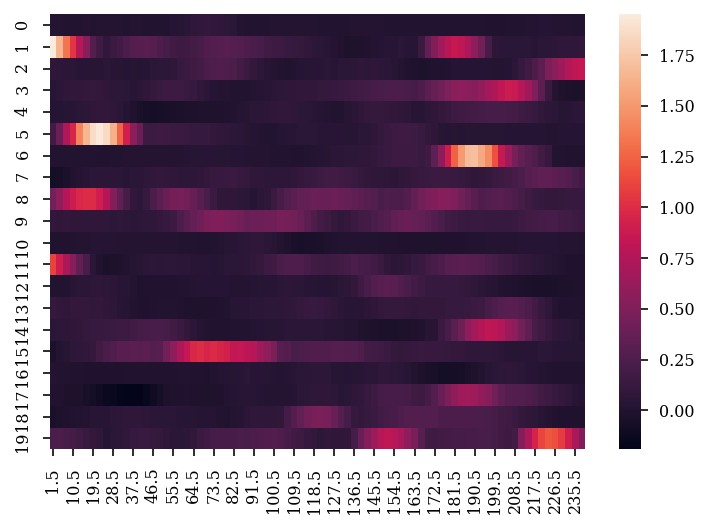

In [190]:
sns.heatmap(results["tc"].T)

In [ ]:
results["label_df"].direction_label == "right_epochs"

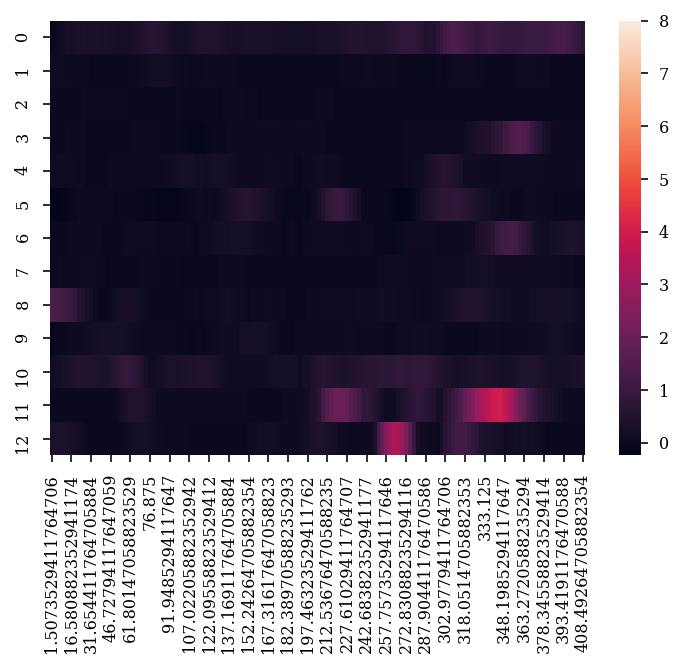

<AxesSubplot:>

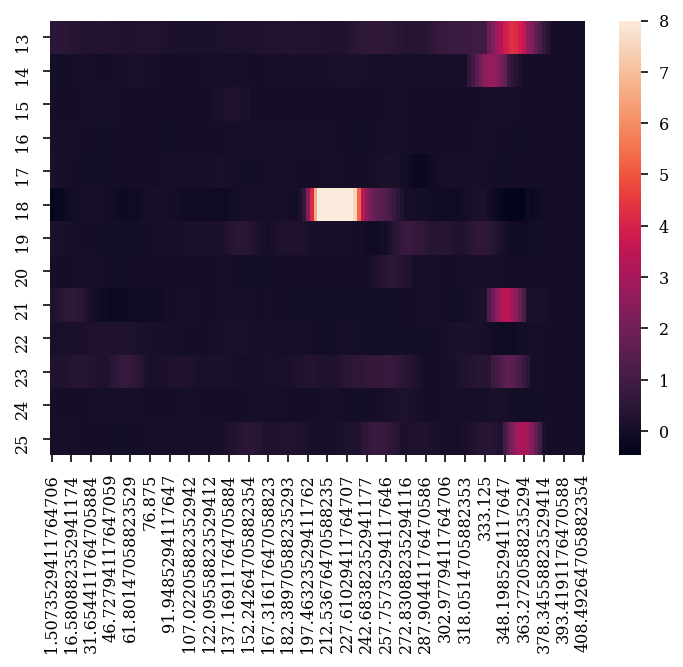

In [128]:

sns.heatmap(results["tc"].loc[:,results["label_df"].direction_label == "right_epochs"].T,vmax=8)
plt.show()
sns.heatmap(results["tc"].loc[:,results["label_df"].direction_label == "left_epochs"].T,vmax=8)


In [37]:
position_df = loading.load_animal_behavior(r"Z:\Data\AYAold\AYA10\day12")
position_df

,time,x,y,linearized,units,projected_x,projected_y,sr,timestamps,speed,acceleration,states,epochs,environment
0,0.0000,NaN,NaN,NaN,cm,NaN,NaN,39.0625,0.0000,NaN,0.0,NaN,trial_1,tmaze
1,0.0256,NaN,NaN,NaN,cm,NaN,NaN,39.0625,0.0256,NaN,NaN,NaN,trial_1,tmaze
2,0.0512,NaN,NaN,NaN,cm,NaN,NaN,39.0625,0.0512,NaN,NaN,NaN,trial_1,tmaze
3,0.0768,NaN,NaN,NaN,cm,NaN,NaN,39.0625,0.0768,NaN,NaN,NaN,trial_1,tmaze
4,0.1024,NaN,NaN,NaN,cm,NaN,NaN,39.0625,0.1024,NaN,NaN,NaN,trial_1,tmaze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558869,14307.0464,NaN,NaN,NaN,cm,NaN,NaN,39.0625,14307.0464,0.0,0.0,NaN,trial_4,sleep
558870,14307.0720,NaN,NaN,NaN,cm,NaN,NaN,39.0625,14307.0720,0.0,0.0,NaN,trial_4,sleep
558871,14307.0976,NaN,NaN,NaN,cm,NaN,NaN,39.0625,14307.0976,0.0,0.0,NaN,NaN,NaN
558872,14307.1232,NaN,NaN,NaN,cm,NaN,NaN,39.0625,14307.1232,NaN,NaN,NaN,NaN,NaN


In [50]:
def find_good_laps(pos, dir_epoch, thres=0.5, binsize=6, min_laps=10):
    """
    find_good_laps: finds good laps in behavior data
        Made to find good laps in nelpy array for replay analysis
    input:
        pos: nelpy analog array with single dim
        dir_epoch: epoch to find good lap
        thres: occupancy threshold for good lap
        binsize: size of bins to calculate occupancy
    output:
        good_laps: epoch array of good laps
    """
    # make bin edges to calc occupancy
    x_edges = np.arange(np.nanmin(pos.data[0]), np.nanmax(pos.data[0]), binsize)
    # initialize occupancy matrix (position x time)
    occ = np.zeros([len(x_edges) - 1, dir_epoch.n_intervals])
    # iterate through laps
    for i, ep in enumerate(dir_epoch):
        # bin position per lap
        occ[:, i], _ = np.histogram(pos[ep].data[0], bins=x_edges)
    # calc percent occupancy over position bins per lap and find good laps
    good_laps = np.where(~((np.sum(occ == 0, axis=0) / occ.shape[0]) > thres))[0]
    # if no good laps, return empty epoch
    if (len(good_laps) == 0) | (len(good_laps) < min_laps):
        dir_epoch = nel.EpochArray()
    else:
        dir_epoch = dir_epoch[good_laps]
    return dir_epoch

In [56]:
np.vstack([position_df.query("epochs=='trial_1' & states==1").timestamps,position_df.query("epochs=='trial_1' & states==1").timestamps])

array([[  76.672 ,   76.6976,   76.7232, ..., 1615.7184, 1615.744 ,
        1615.7696],
       [  76.672 ,   76.6976,   76.7232, ..., 1615.7184, 1615.744 ,
        1615.7696]])

In [59]:
position_df.query("epochs=='trial_1' & states==1").timestamps

2995       76.6720
2996       76.6976
2997       76.7232
3040       77.8240
3041       77.8496
           ...    
62842    1608.7552
62843    1608.7808
63114    1615.7184
63115    1615.7440
63116    1615.7696
Name: timestamps, Length: 22745, dtype: float64

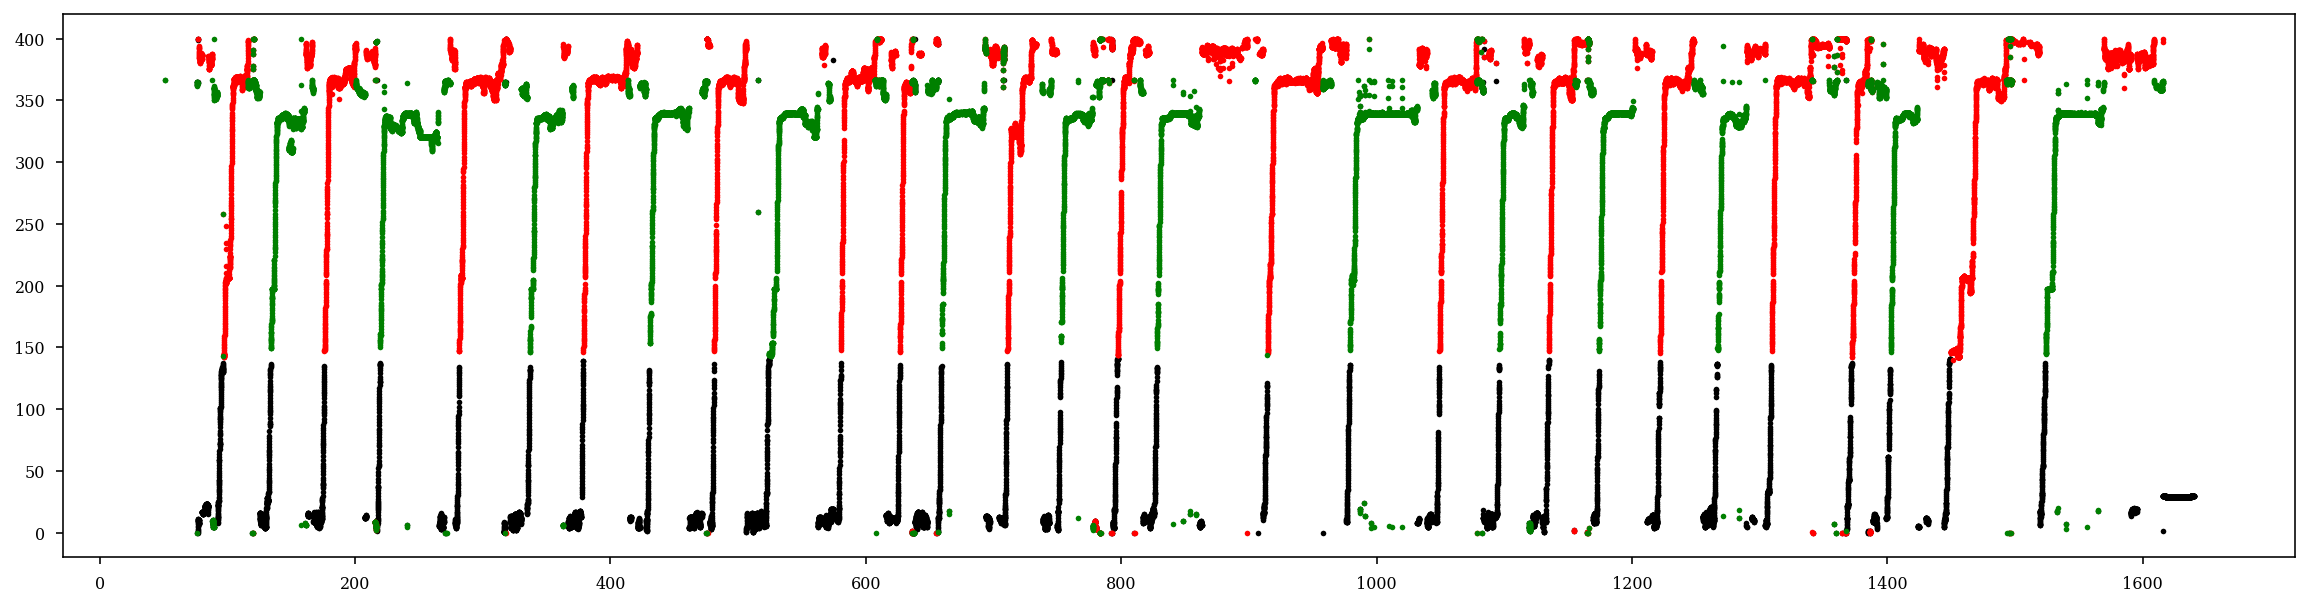

In [72]:
    
state_0_epochs = nel.EpochArray(
    np.vstack(
        [
            position_df.query("epochs=='trial_1' & states==0").timestamps,
            position_df.query("epochs=='trial_1' & states==0").timestamps,
        ]
    ).T
).merge(gap=1)

state_1_epochs = nel.EpochArray(
    np.vstack(
        [
            position_df.query("epochs=='trial_1' & states==1").timestamps,
            position_df.query("epochs=='trial_1' & states==1").timestamps,
        ]
    ).T
).merge(gap=1)

state_2_epochs = nel.EpochArray(
    np.vstack(
        [
            position_df.query("epochs=='trial_1' & states==2").timestamps,
            position_df.query("epochs=='trial_1' & states==2").timestamps,
        ]
    ).T
).merge(gap=1)

plt.figure(figsize=(20,5))

plt.plot(pos[state_0_epochs].abscissa_vals, pos[state_0_epochs].data[0],'.k')
plt.plot(pos[state_1_epochs].abscissa_vals, pos[state_1_epochs].data[0],'.r')
plt.plot(pos[state_2_epochs].abscissa_vals, pos[state_2_epochs].data[0],'.g')

plt.show()

In [101]:
def dissociate_laps_by_states(states, dir_epoch, states_of_interest=[1,2]):
    # unique_states = np.unique(states.data[~np.isnan(states.data)])
    lap_id = []
    for ep in dir_epoch:
        state_count = []
        for us in states_of_interest:
            state_count.append(np.nansum(states[ep].data == us))
        lap_id.append(states_of_interest[np.argmax(state_count)])
    return np.array(lap_id).astype(int)

In [112]:

inbound_epochs


<empty EpochArray at 0x1ddfb9df310>

(<EpochArray at 0x1ddfb9df6d0: 16 epochs> of length 7:48:454 minutes,
 <EpochArray at 0x1de10295580: 14 epochs> of length 4:58:188 minutes)

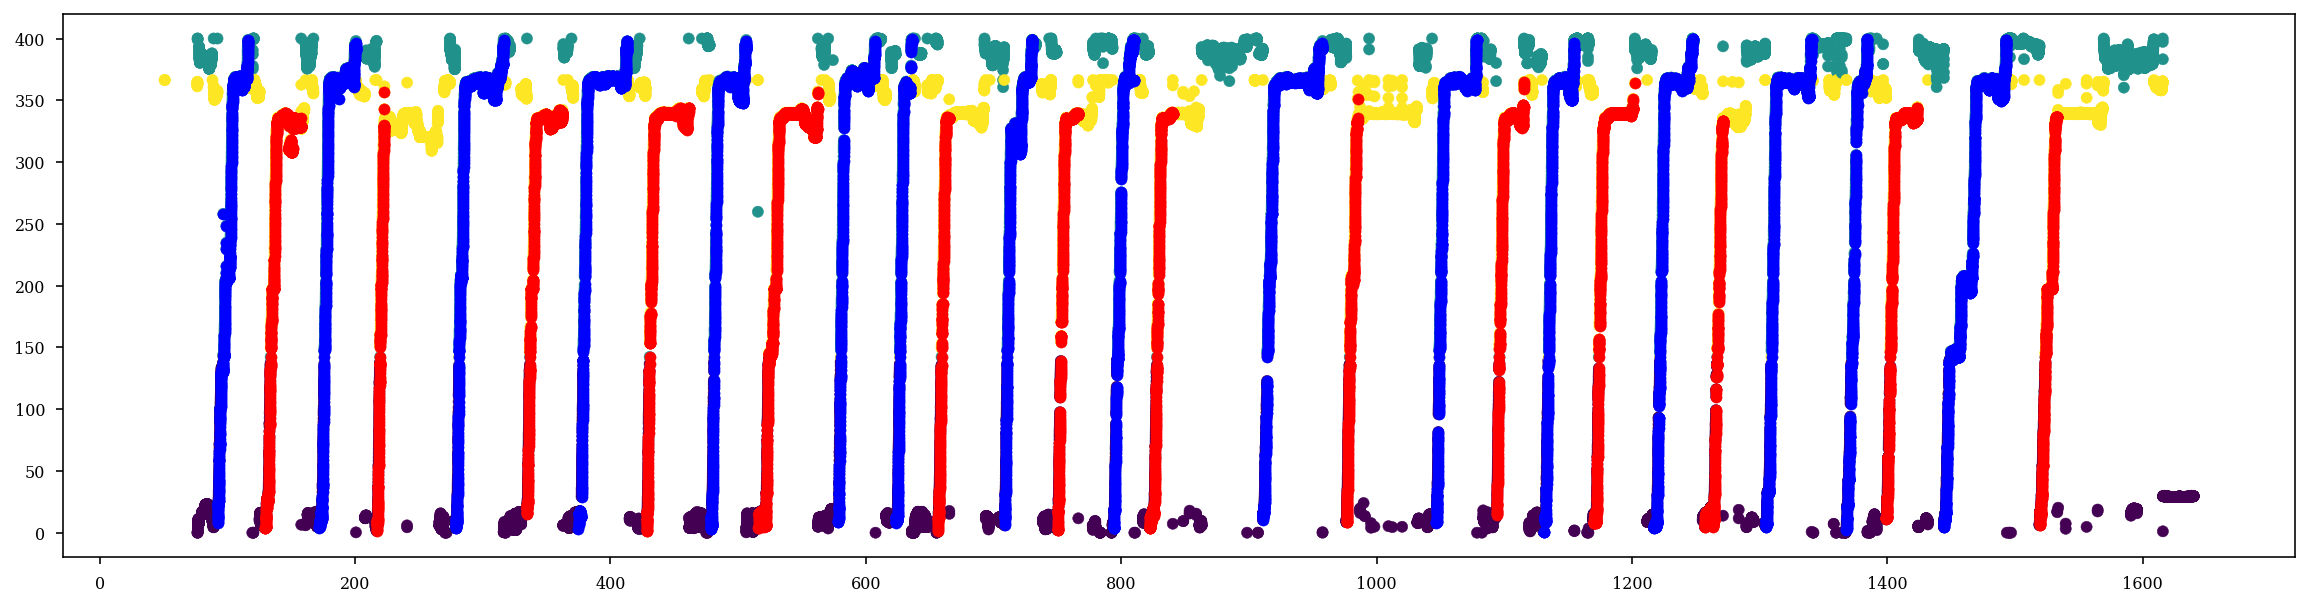

In [111]:
plt.figure(figsize=(20,5))
plt.scatter(
    position_df.query("epochs=='trial_1'").timestamps,
    position_df.query("epochs=='trial_1'").linearized,
    c=position_df.query("epochs=='trial_1'").states,
)
# plt.show()

outbound_epochs, inbound_epochs = functions.get_linear_track_lap_epochs(
    position_df.query("epochs=='trial_1'").timestamps, position_df.query("epochs=='trial_1'").linearized, newLapThreshold=20
)
pos = nel.PositionArray(
    data=position_df.query("epochs=='trial_1'")["linearized"].values.T,
    timestamps=position_df.query("epochs=='trial_1'").timestamps.values,
)
states = nel.AnalogSignalArray(data=position_df.query("epochs=='trial_1'")["states"].values.T,
    timestamps=position_df.query("epochs=='trial_1'").timestamps.values)

outbound_epochs = functions.find_good_lap_epochs(pos, outbound_epochs)
inbound_epochs = functions.find_good_lap_epochs(pos, inbound_epochs)

lap_id = dissociate_laps_by_states(states, outbound_epochs, states_of_interest=[1,2])
right_epochs = nel.EpochArray(data=outbound_epochs.data[lap_id==1,:])
left_epochs = nel.EpochArray(data=outbound_epochs.data[lap_id==2,:])

# plt.figure(figsize=(20,5))
plt.scatter(
    pos[right_epochs].abscissa_vals,
    pos[right_epochs].data[0].T,
    color="b"
)
plt.scatter(
    pos[left_epochs].abscissa_vals,
    pos[left_epochs].data[0].T,
    color="r"
)
right_epochs,left_epochs

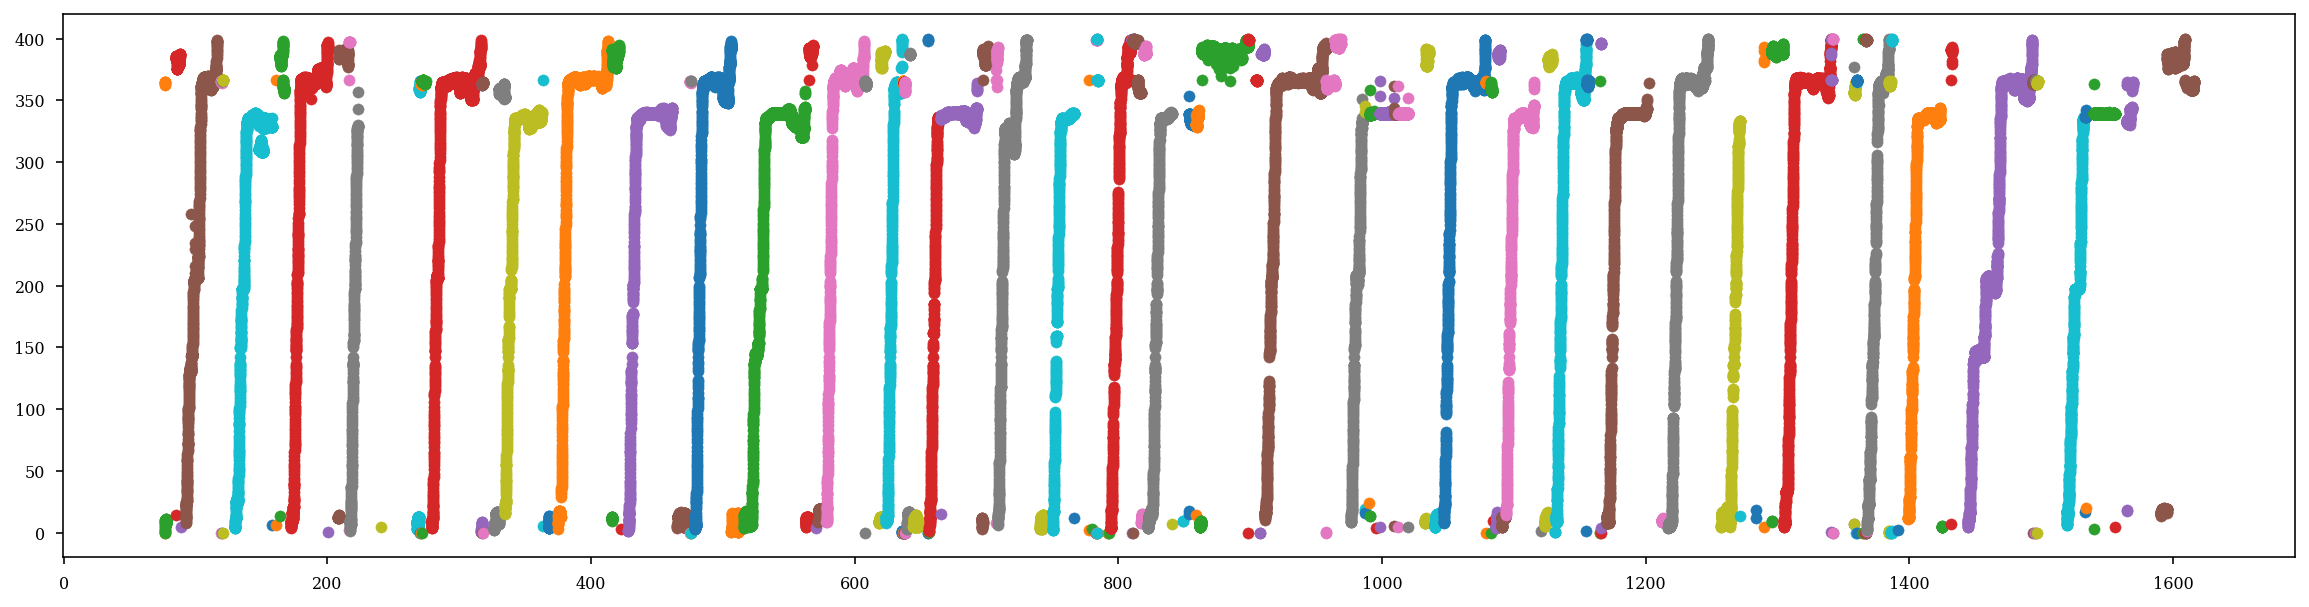

In [49]:
import logging
logging.getLogger().setLevel(logging.ERROR)
plt.figure(figsize=(20,5))

for ep in outbound_epochs:
    plt.scatter(
        pos[ep].abscissa_vals,
        pos[ep].data[0].T,
    )

In [ ]:
for basepath in epoch_df.query("environment == 'tmaze' & (mec|pfc)").basepath.unique():
    epoch_df_current = loading.load_epoch(basepath)

    startTime = epoch_df_current[epoch_df_current.environment == 'tmaze'].startTime
    stopTime = epoch_df_current[epoch_df_current.environment == 'tmaze'].stopTime

    position_df = loading.load_animal_behavior(basepath)
    try:
        position_df.timestamps 
    except:
        continue
    idx = (position_df.timestamps > startTime.iloc[0]) & (position_df.timestamps < stopTime.iloc[0])
    plt.plot(position_df[idx].x,position_df[idx].y)
    plt.axis("equal")
    plt.title(basepath)
    plt.show()    

In [ ]:
for basepath in epoch_df.query("environment.str.contains('Mwheel|Tmaze|tmaze|wmaze') & (mec|pfc)").basepath.unique():
    position_df = loading.load_animal_behavior(basepath)
    plt.plot(position_df.x,position_df.y)
    plt.axis("equal")
    plt.title(basepath)
    plt.show()    